In [1]:
from utils import DEVICE, SYMBOLS, ID2SYM, SYM2ID
import time
from tqdm import tqdm
from collections import Counter

from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from dataset import HINT, HINT_collate
from jointer import Jointer
from train import parse_args, draw_parse

import torch
import numpy as np
import random
torch.multiprocessing.set_sharing_strategy('file_system')

import argparse
import sys

from PIL import Image
from nltk import Tree
from nltk.draw.util import CanvasFrame
from nltk.draw import TreeWidget
import os

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
symbol_images_dir = 'data/symbol_images/'
def render_img(img_paths):
    images = [Image.open(symbol_images_dir + x) for x in img_paths]
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
    return new_im

def jupyter_draw_nltk_tree(tree):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 13 bold'
    tc['leaf_font'] = 'arial 14'
    tc['node_color'] = '#005990'
    tc['leaf_color'] = '#3F8F57'
    tc['line_color'] = '#175252'
    cf.add_widget(tc, 0, 0)
    cf.canvas()['scrollregion'] = tc.bbox()
    cf.print_to_file('tmp/tree.ps')
    cf.destroy()
    os.system('convert -density 300 -depth 8 -quality 90 tmp/tree.ps tmp/tree.png')
    
    # display
    im = Image.open('tmp/tree.png')
#     width, height = im.size
#     height = int(height * tree.height() / 10)
#     im = im.crop((0, 0, width, height))
    display(im)

def draw_ast(ast):
    sentence = ''.join(map(ID2SYM, ast.pt.sentence))
    res = ast.res_all()
    head = ast.pt.head
    tree = draw_parse(list(zip(sentence, res)), head)
    return tree

In [9]:
train_set = HINT('train')
val_set = HINT('val')
# test_set = HINT('val')
test_set = HINT('test')
print('train:', len(train_set), 'val:', len(val_set), 'test:', len(test_set))

train: 11170 val: 4900 test: 48910


# Visualize model predictions

In [10]:
sys.argv = sys.argv[:1]
args = parse_args()
args.resume = 'experiments/model_100.p'
model = Jointer(args)
model.to(DEVICE)
if args.perception_pretrain and not args.perception:
    model.perception.load({'model': torch.load(args.perception_pretrain)})

st_epoch = 0
if args.resume:
    st_epoch = model.load(args.resume)
    if st_epoch is None:
        st_epoch = 0

print(args)
model.print()

CUDA is available?: True
using cuda?: True
Namespace(curriculum=False, epochs=100, epochs_eval=10, excludes='!', fewshot=-1, output_dir='outputs/', perception=False, perception_pretrain='data/perception-pretrain/model.pth.tar_78.2_match', resume='experiments/model_100.p', seed=0, semantics=False, syntax=False)
ClusteringModel(
  (backbone): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      

Test subset  1
GT: 6+4 = 10
PD: 6+4 = 10


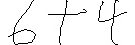

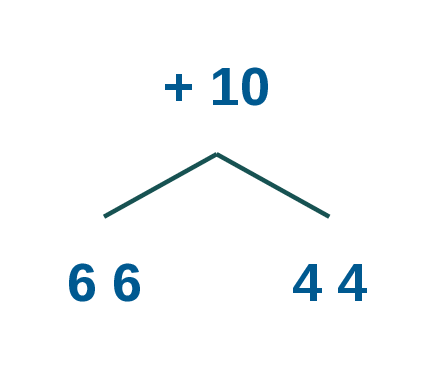

GT: 0 = 0
PD: 0 = 0


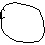

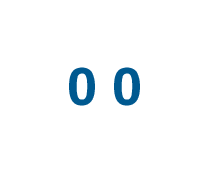

GT: 2/6 = 1
PD: 2/6 = 1


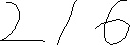

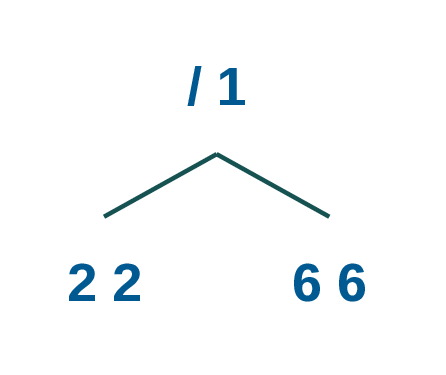

GT: (0-3+6)*9 = 54
PD: (0-3+6)*9 = 54


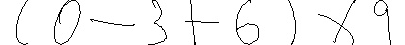

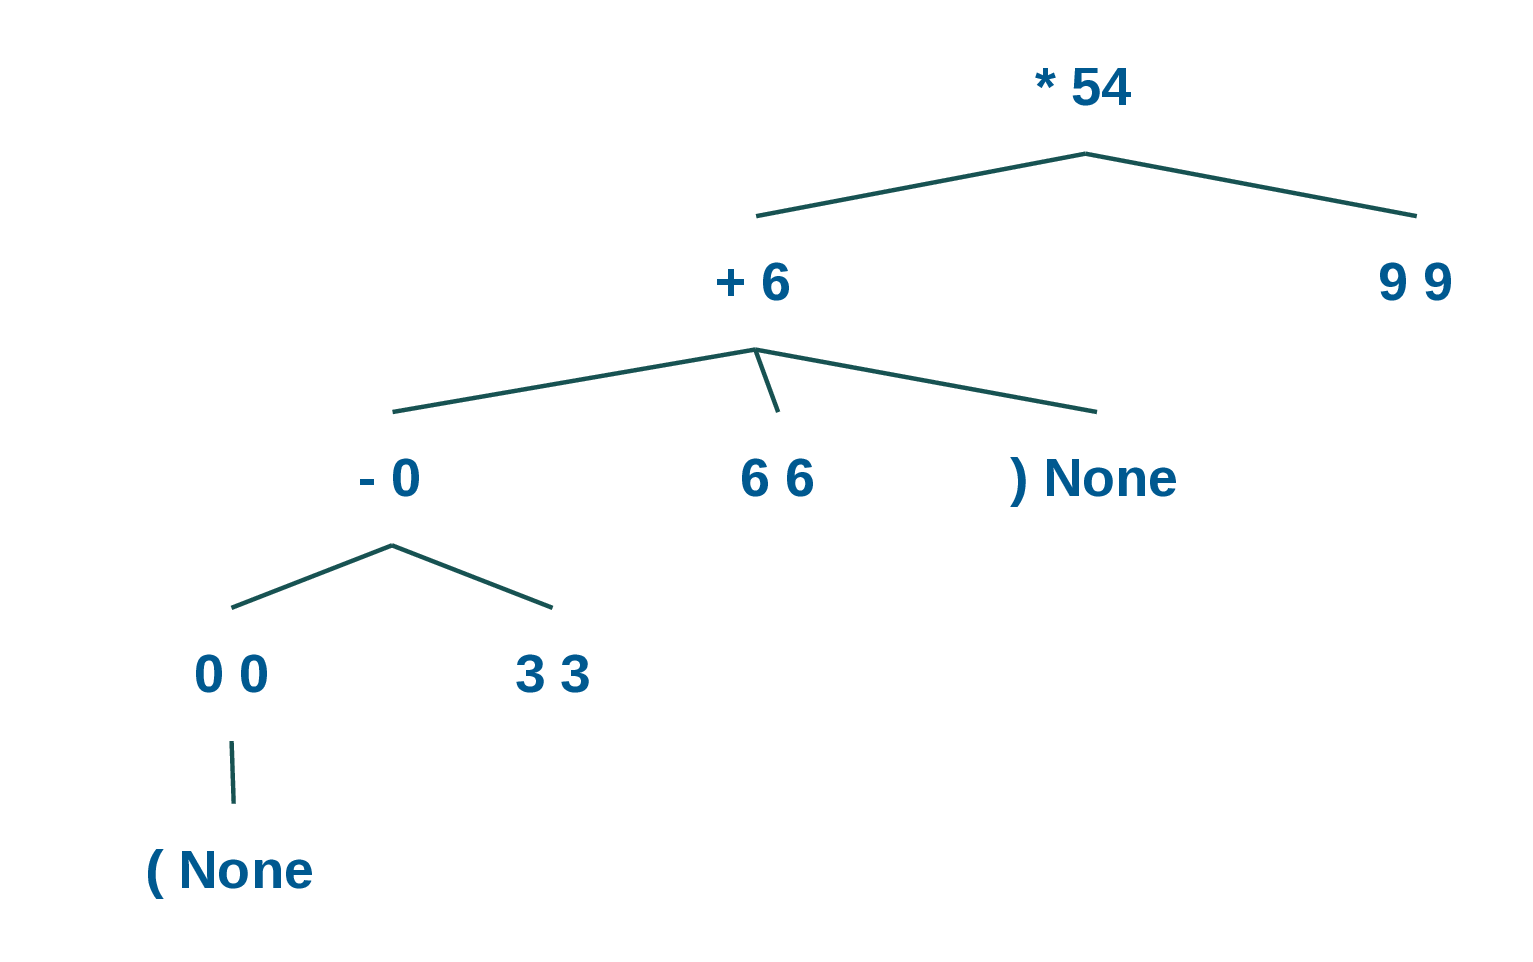

GT: (2+7/2)/((6+1)/(8+0*(0*6)))-(4-3) = 5
PD: (2+7/2(/)(6+1)/(8+0*(0*6)))-(4-3) = 0


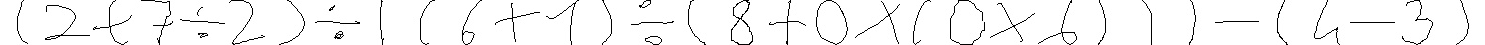

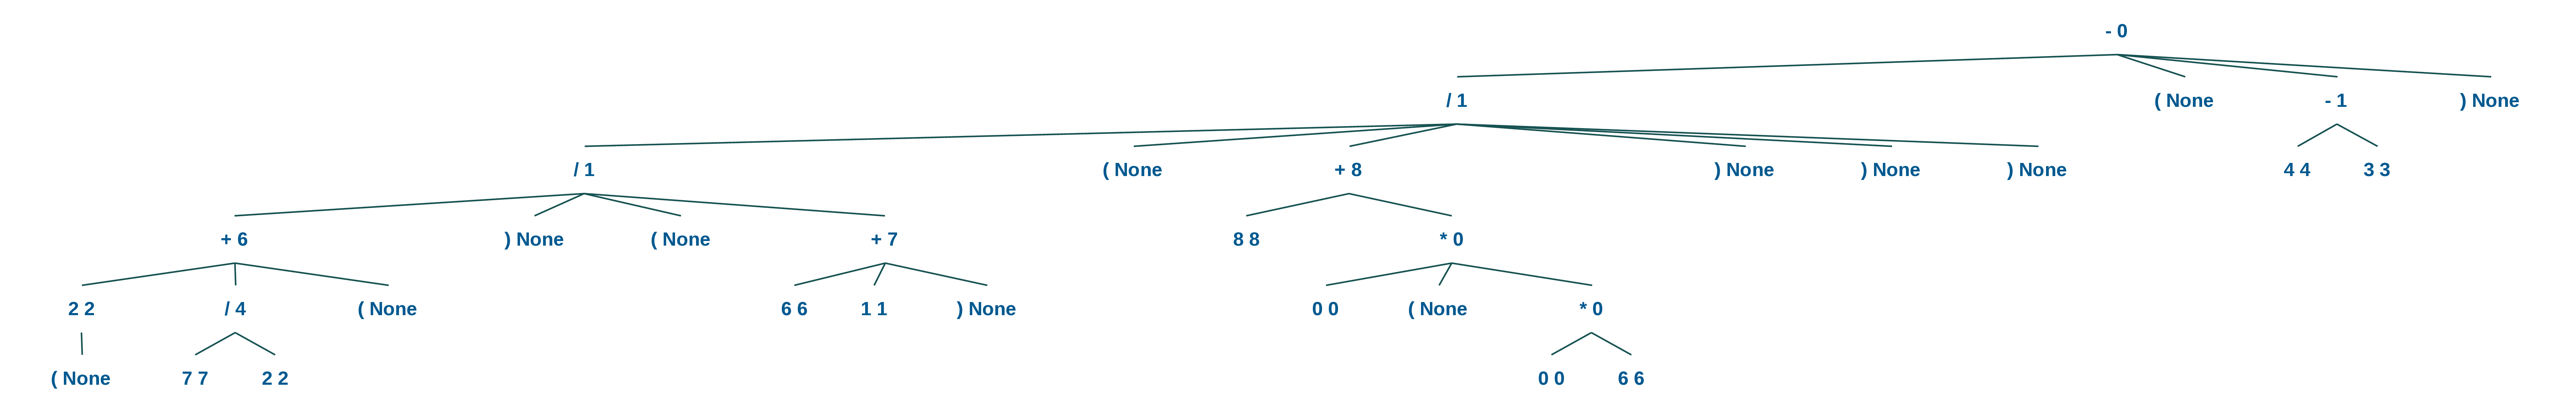

Test subset  2
GT: 2*9-3-(6+(3+5)+8)-(2*3+9-3-3) = 0
PD: 2*9-3-(6+(3+5)+8(-(2*3+9-3-3( = 0


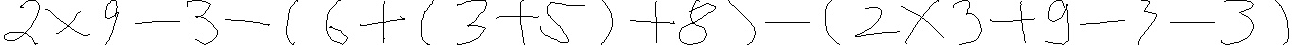

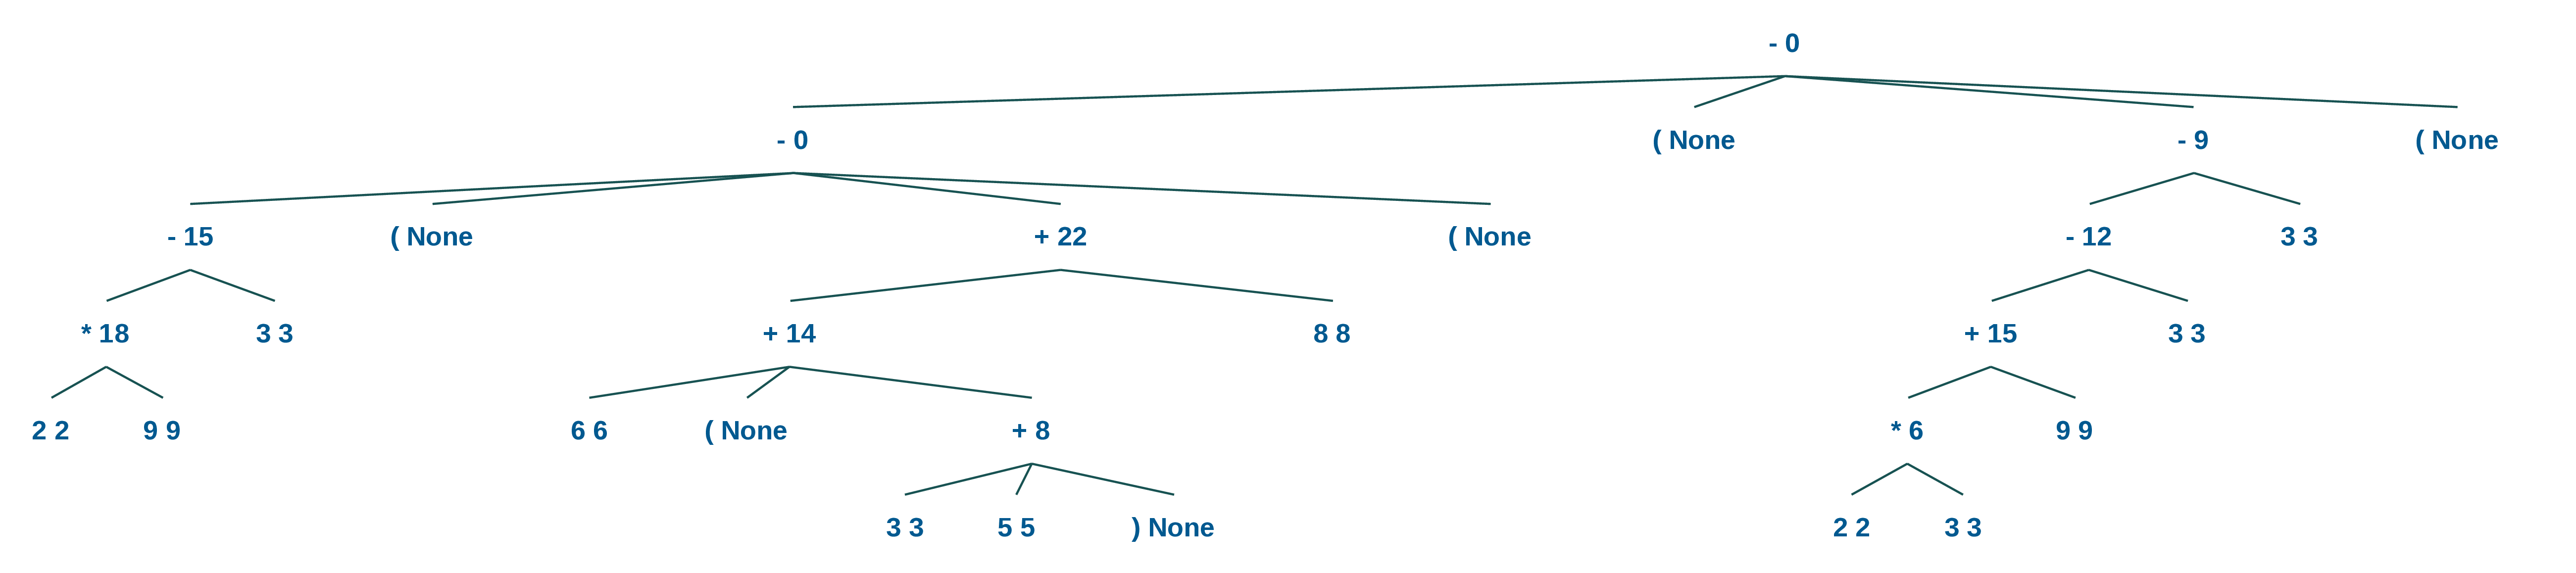

GT: 6-((9+4+0)/(2-1)+5*(2-7)) = 0
PD: 6-((9+4+0)/(2-1)+5*(2-7)) = 0


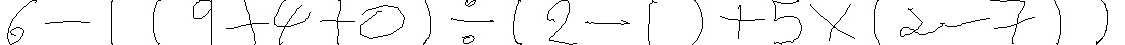

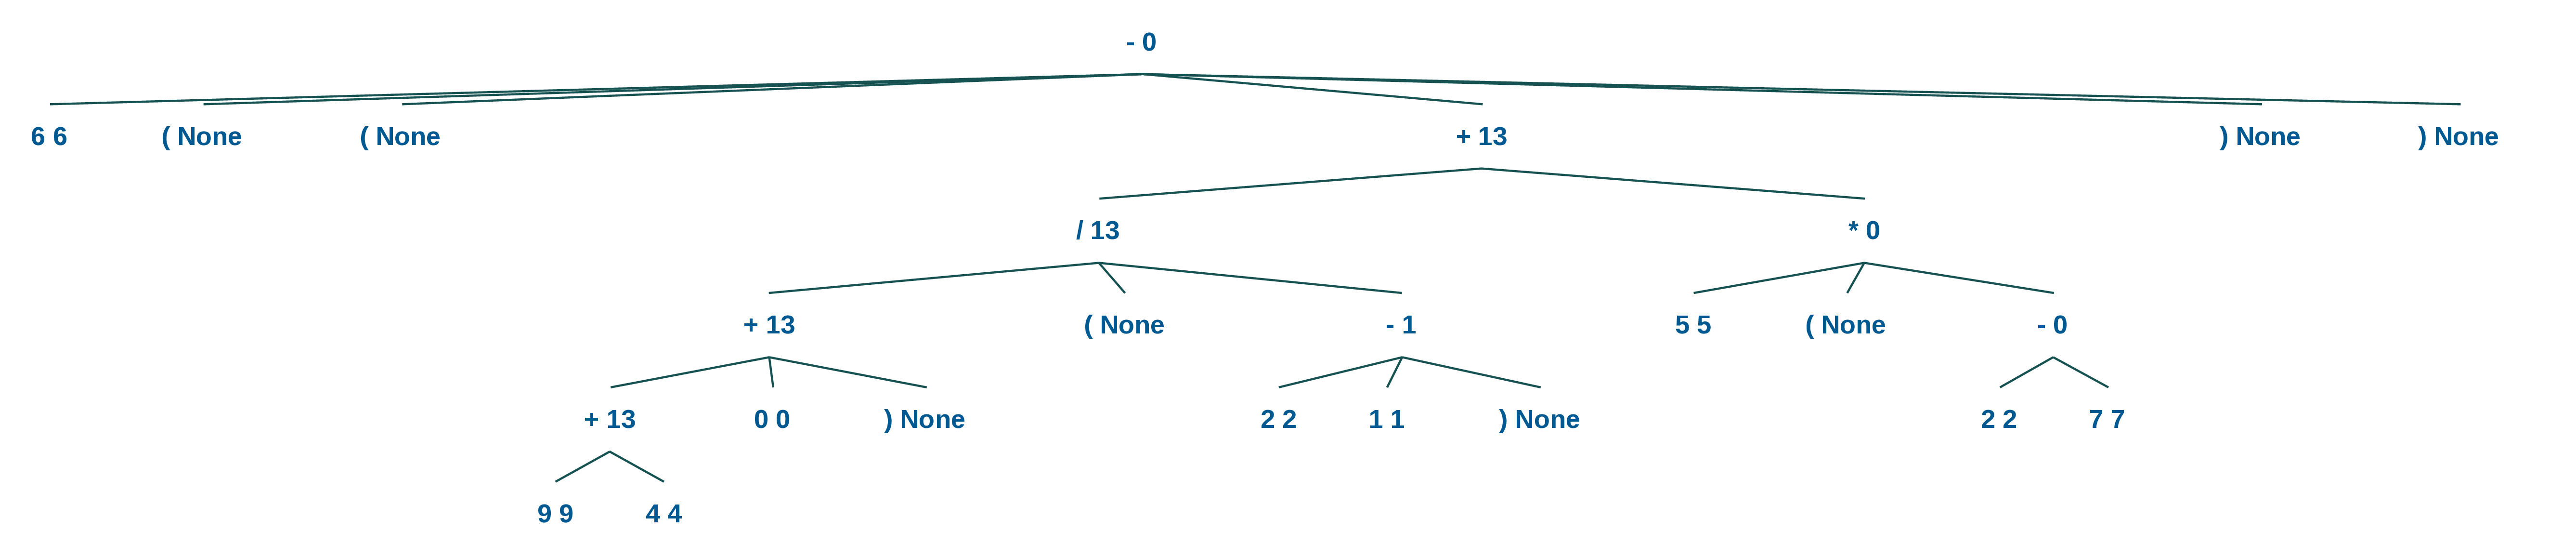

GT: (0*2+5+2/(0/3/7+9))/(8+(3+5*2-8)) = 1
PD: (0*2+5+2/(0/3/7+9()/(8+(3+5*2-8)) = 1


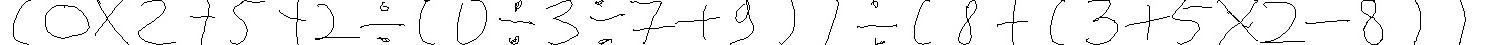

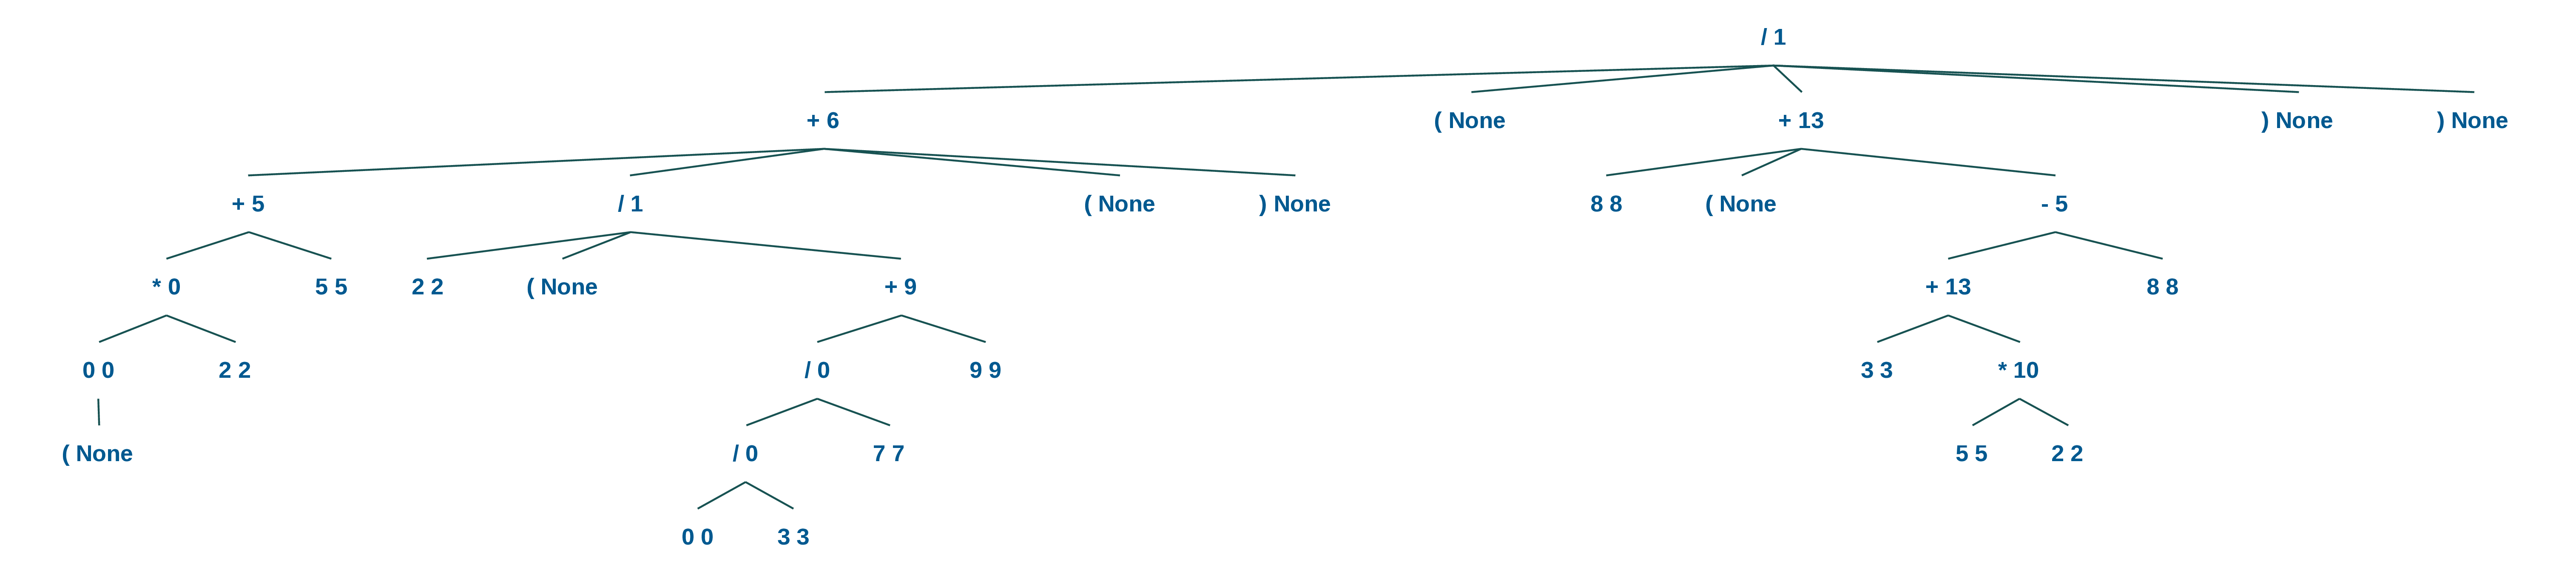

GT: 6-3*9 = 0
PD: 6-3*9 = 0


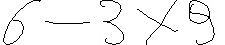

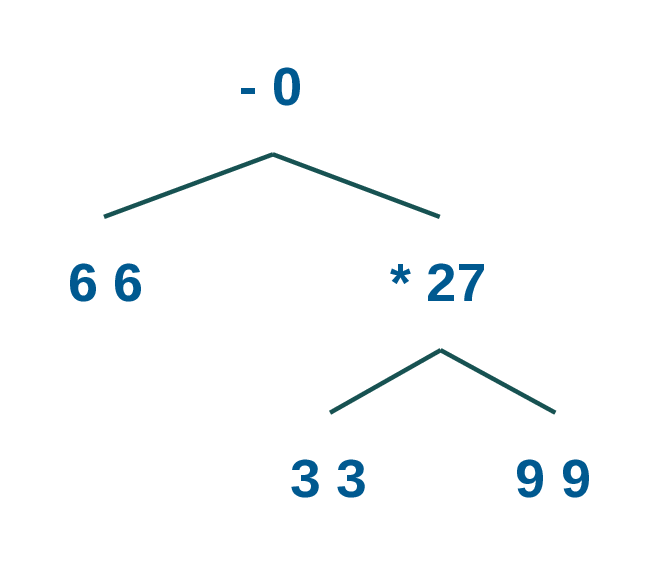

GT: (3/(7/6)+1+2*5)/2/(1*7)*(9/7-7) = 0
PD: (3/(7/6(+0+2*5)/2/(1*7(*(9/7-7) = 0


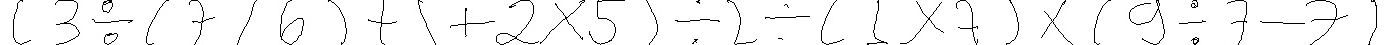

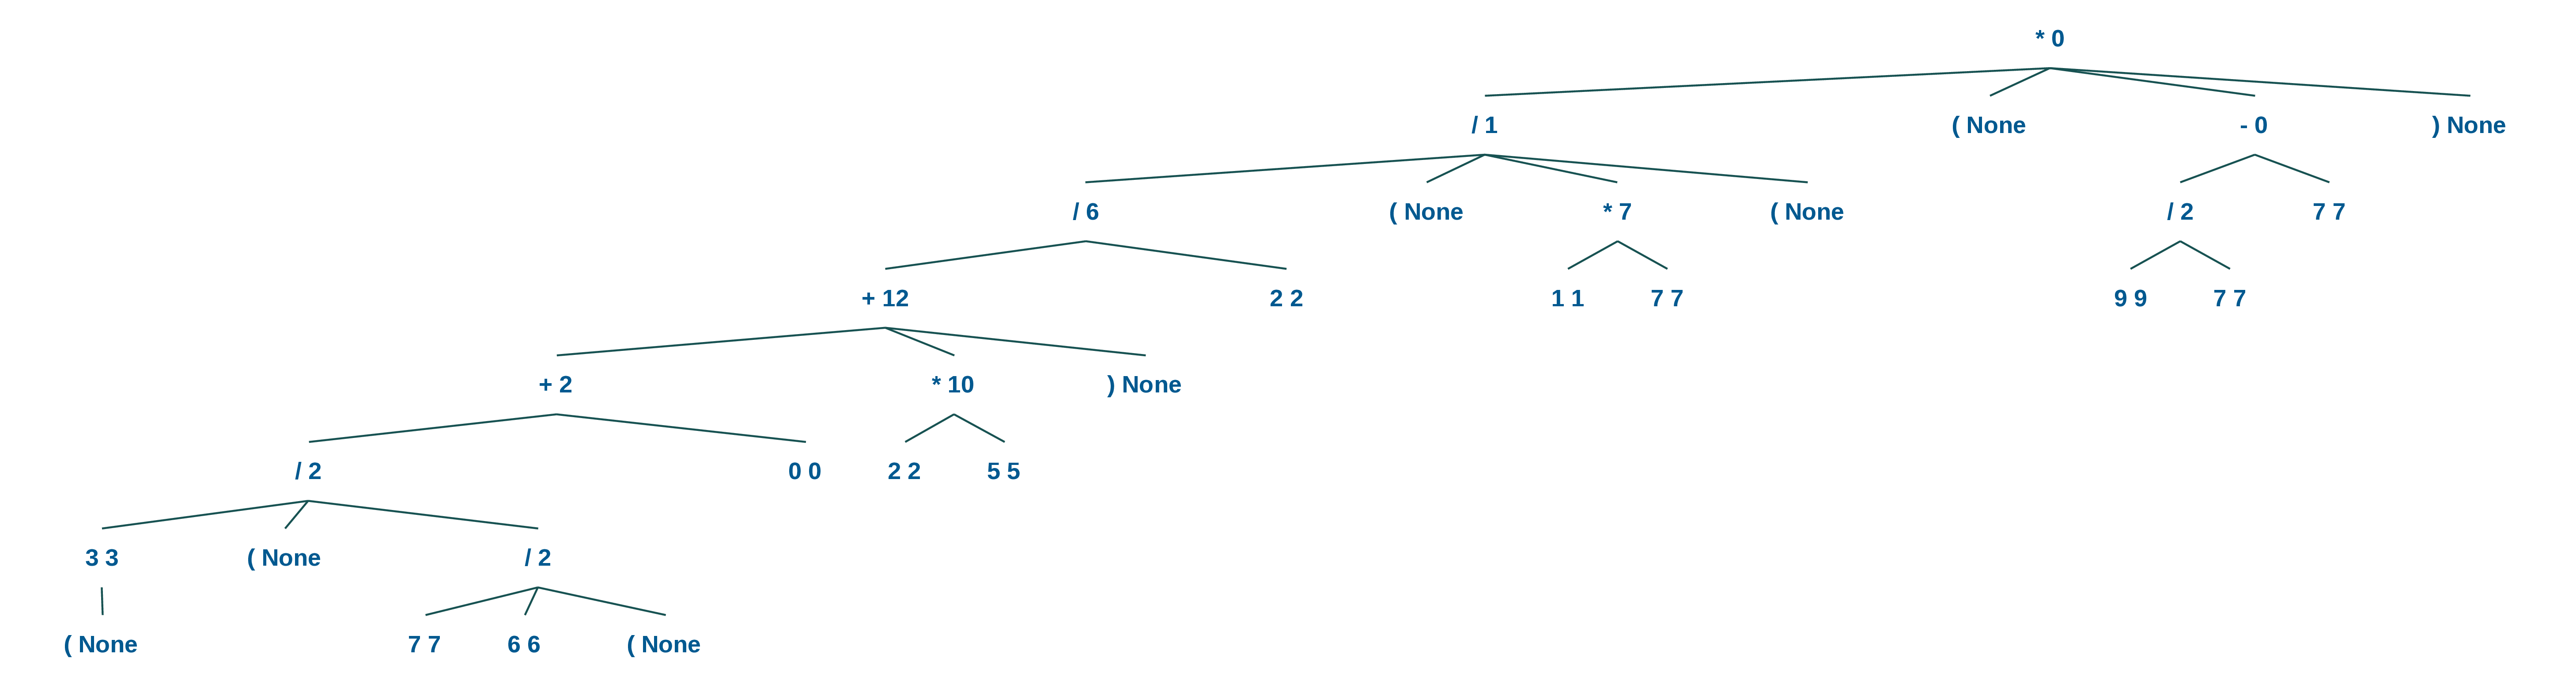

Test subset  3
GT: 9*4*(6*8*(2/4))-6+(4-9)-(6/1+(4*0+5)) = 1711
PD: 9*4*(6*0*(2/4((-6+(4-9)-(6/1+(4*0+5() = 0


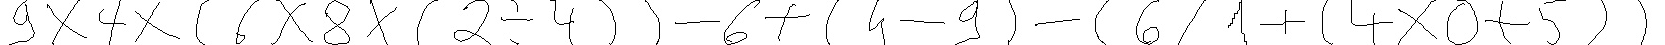

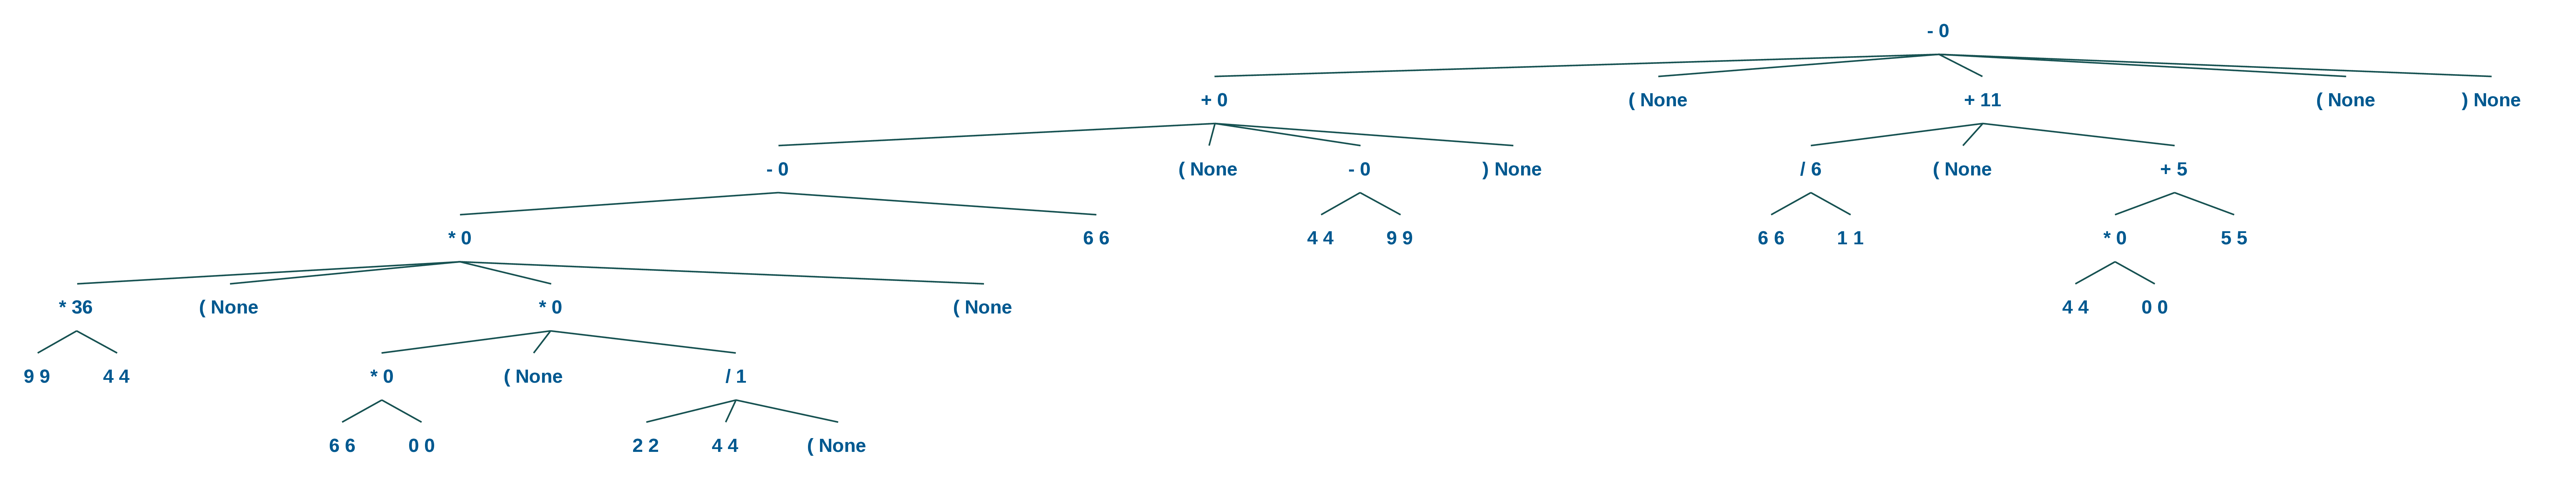

GT: (7*6+8-5+(2-8)*9)/(7*(9*7)) = 1
PD: (7*6+8-5+(2-8(*9(/(7*(9*7)( = 1


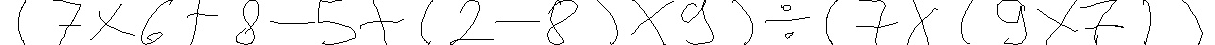

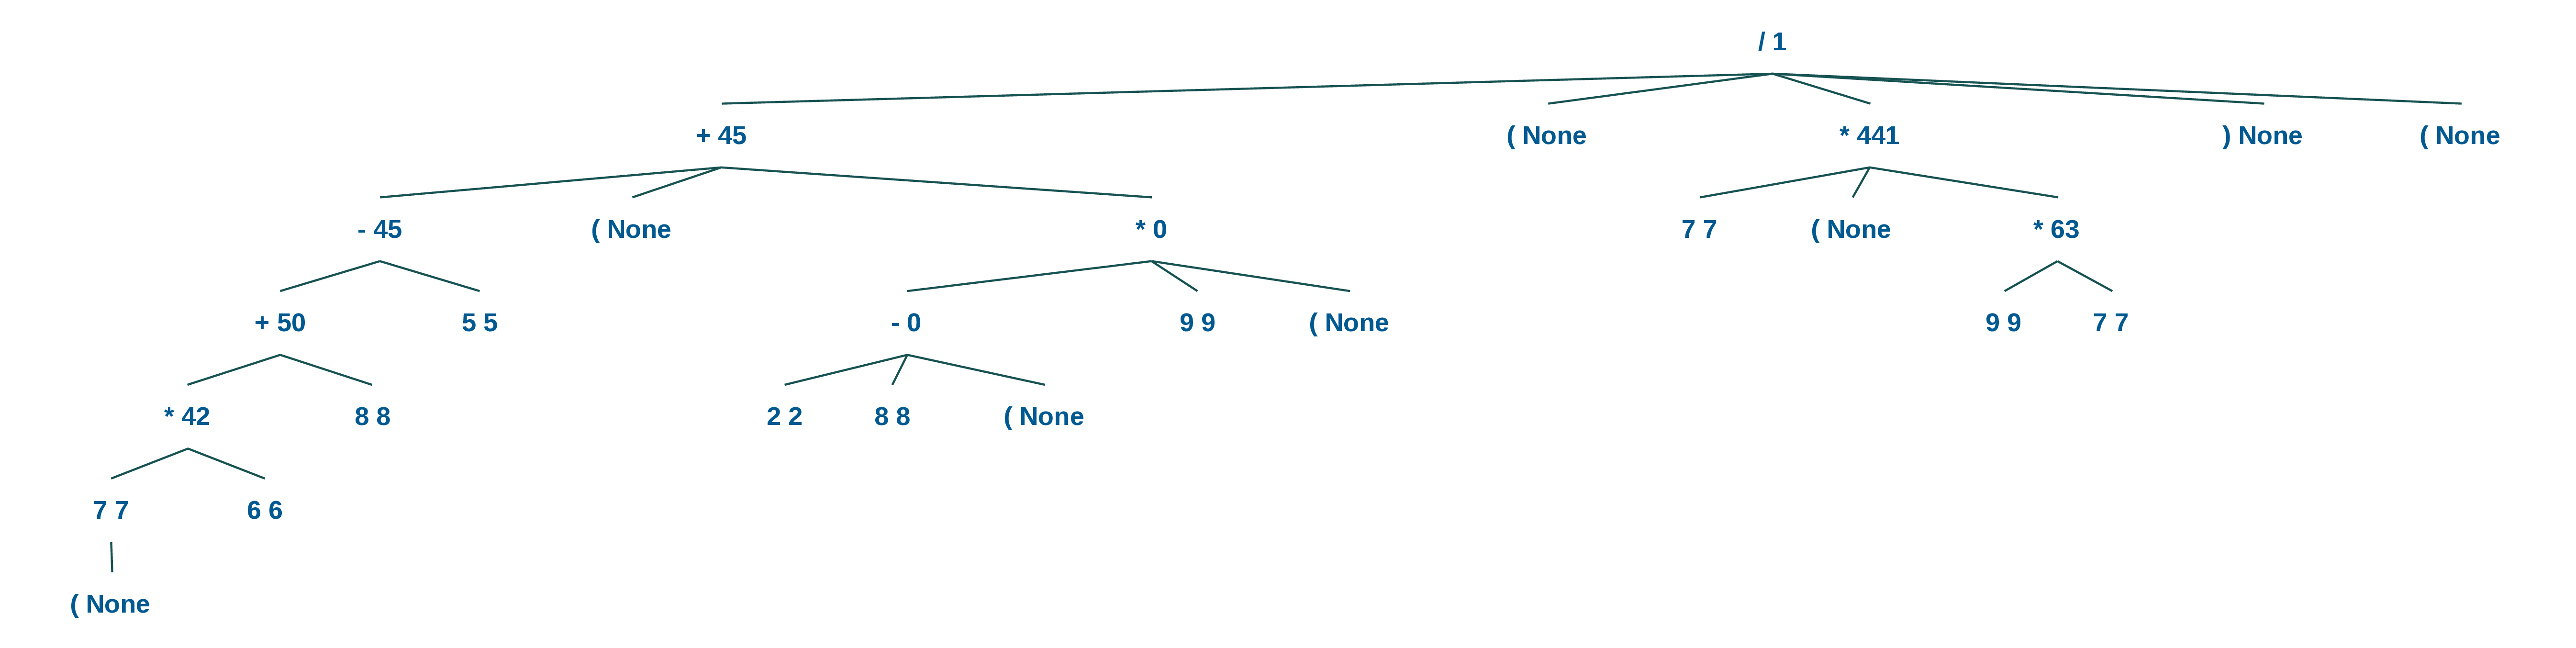

GT: 9*5*7/9+(4-7+(6+1))/(9+6) = 36
PD: 9*5*7/9+(4-7+(6+1))/(9+6) = 36


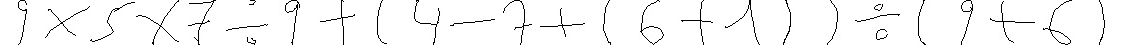

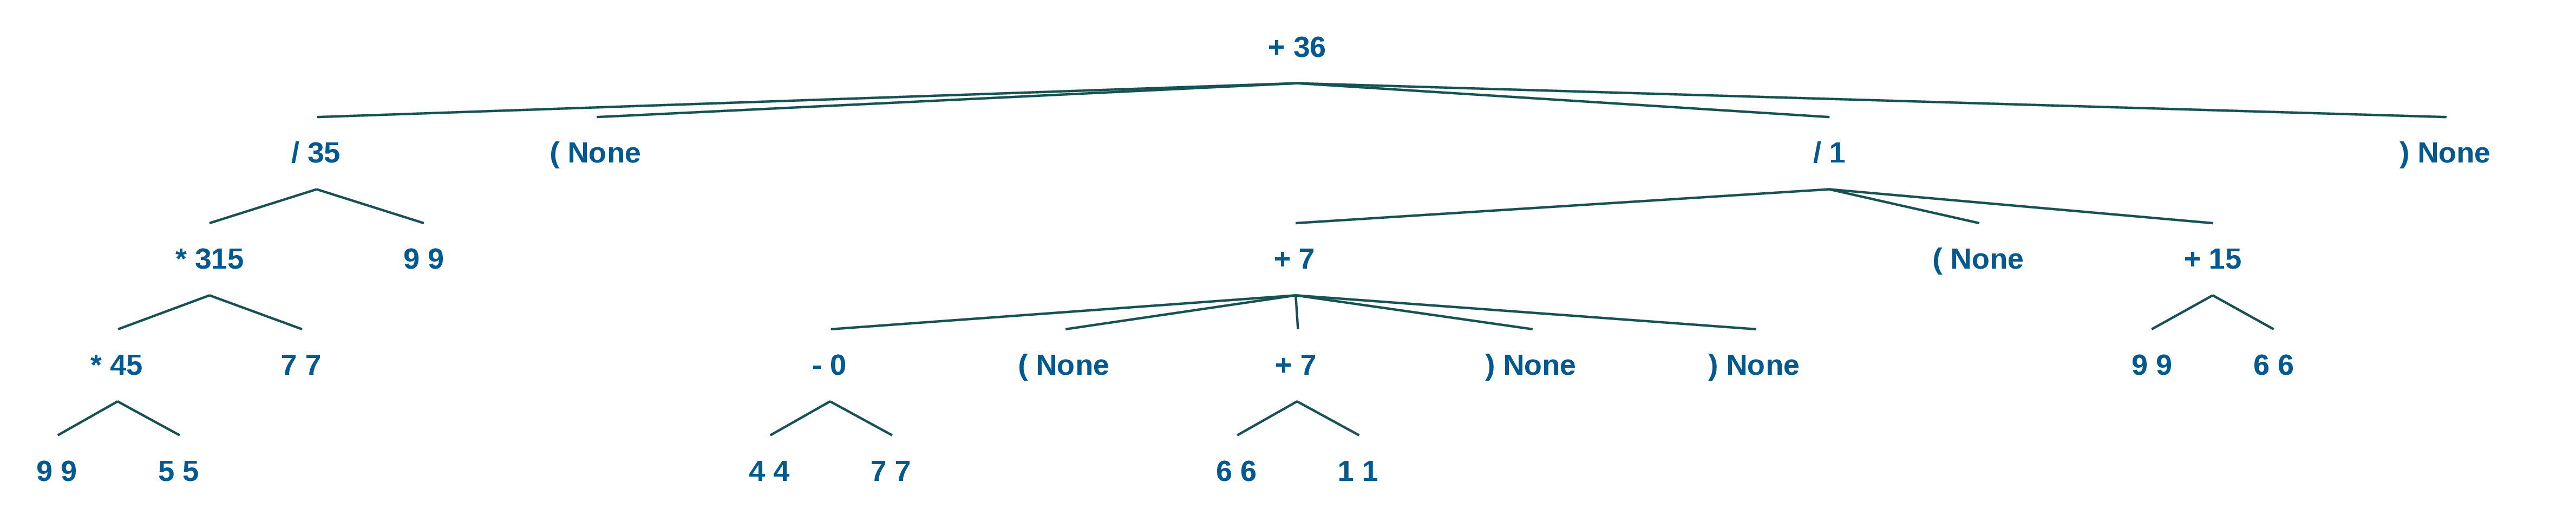

GT: (9+4+5*3*6)/(1*2) = 52
PD: (9+4+5*3*6(/(1*2) = 58


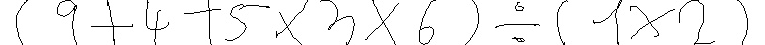

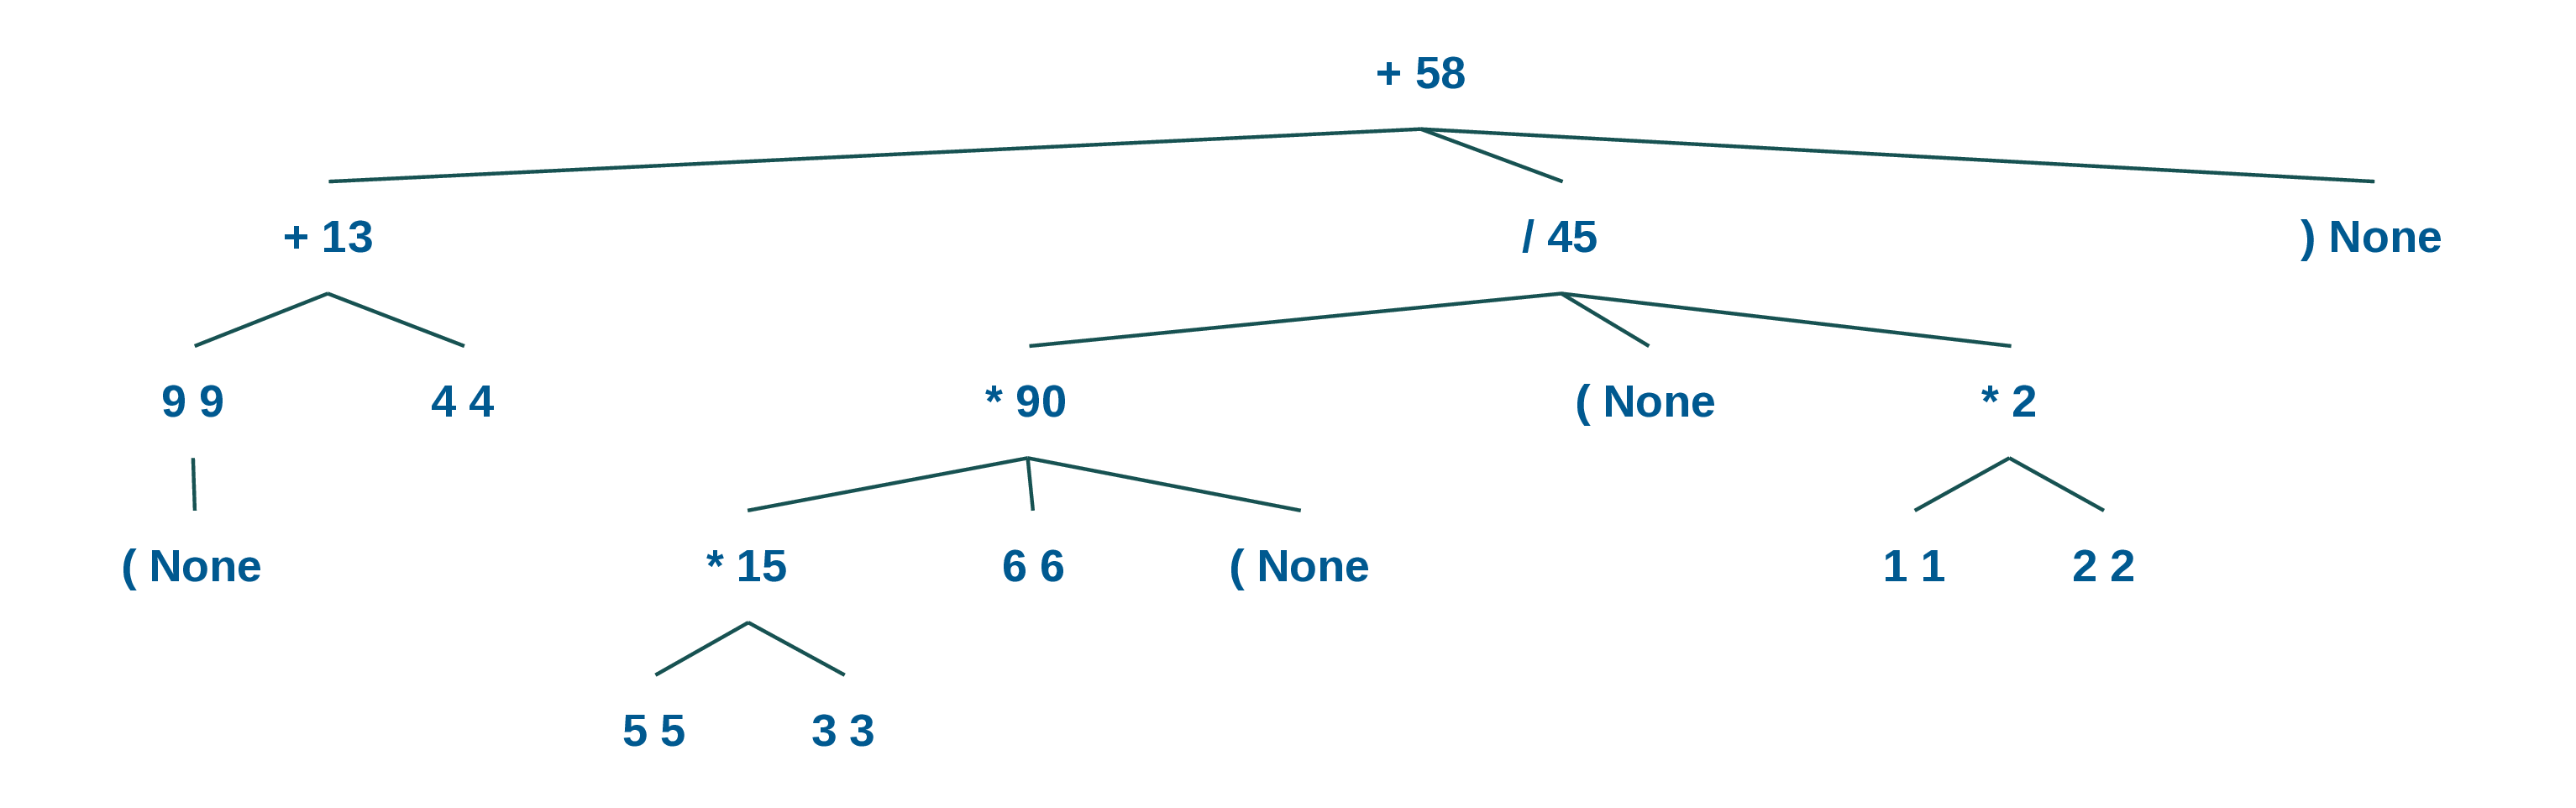

GT: 7-9*(4-0/5)*(9*(3+5))+(0+(3+8)) = 11
PD: 7-9*(4-0/5)*(9*(3+5))+(0+(3+8)) = None


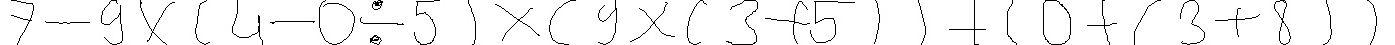

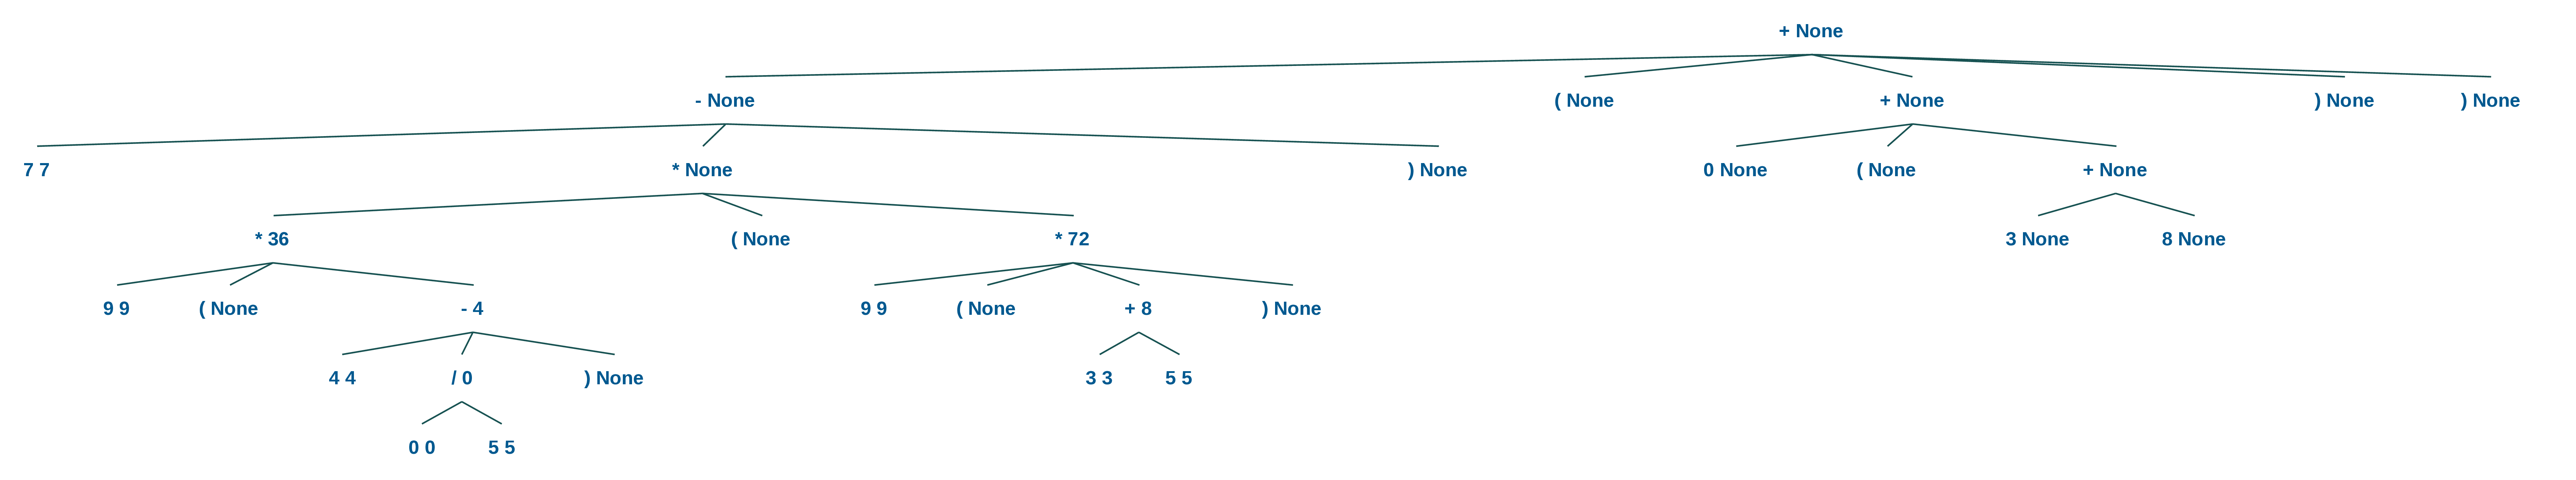

Test subset  4
GT: (1+(3+2))*(9/4/(9+(5-0))/1+0/6)-(5-5+6*3-7*4)-(8-7/5)*4 = 0
PD: (1+(3+2))*(9/4/(9+(5-0()/1+0/6)-(5-5+6*3-7*4)-(8-7/5(*4 = 0


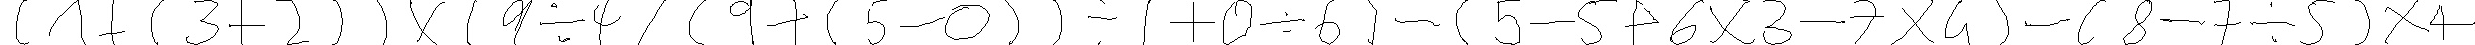

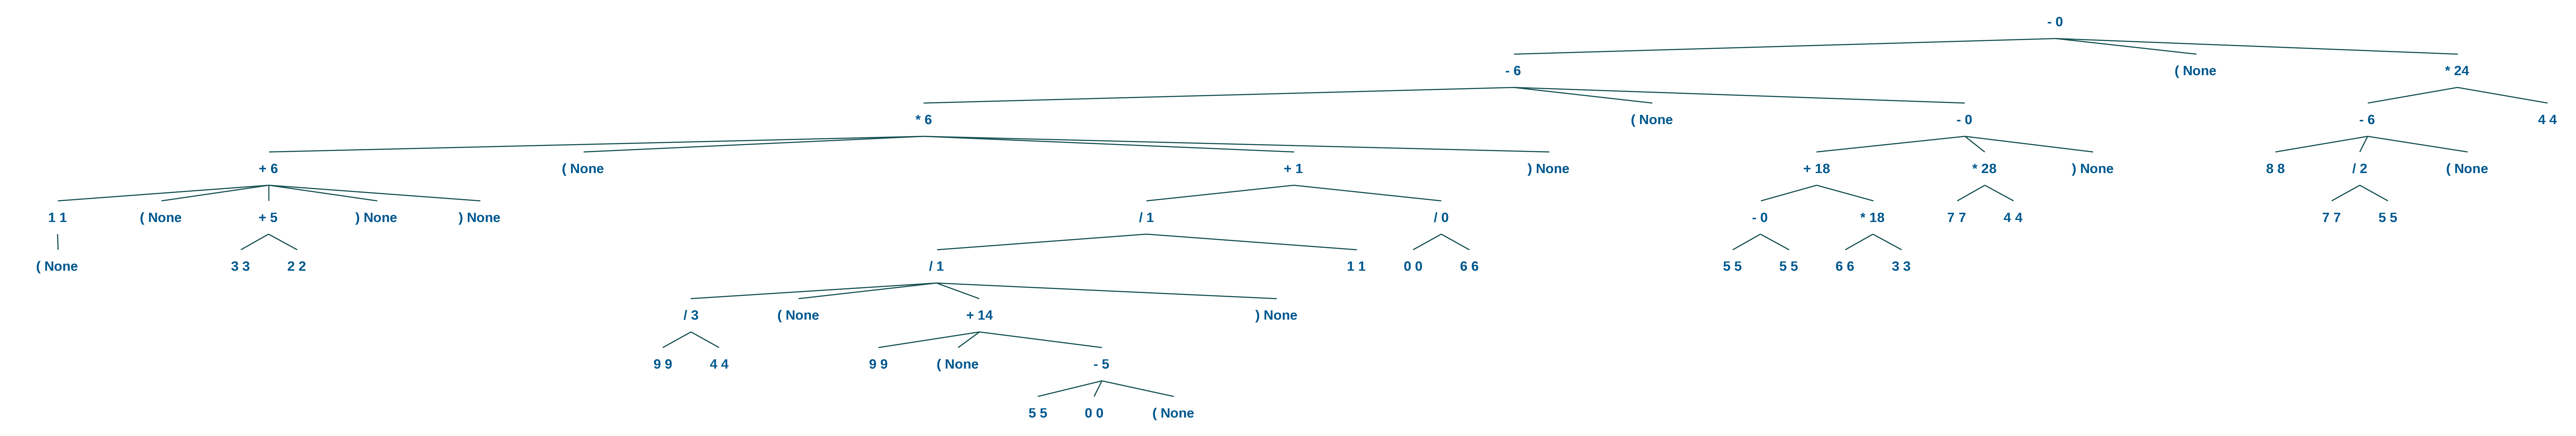

GT: 4+2-9/1-(5+7)+(6+6)/(4*2/4)/(8+8/(7+3)-7) = 3
PD: 4+2-9/1-)5+7)+(0+6(/(4*2/4)/(8+8/(7+3)-7( = 2


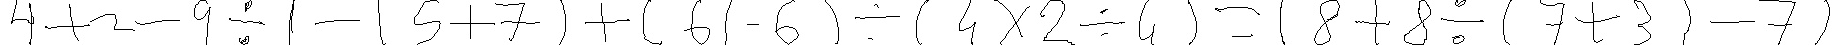

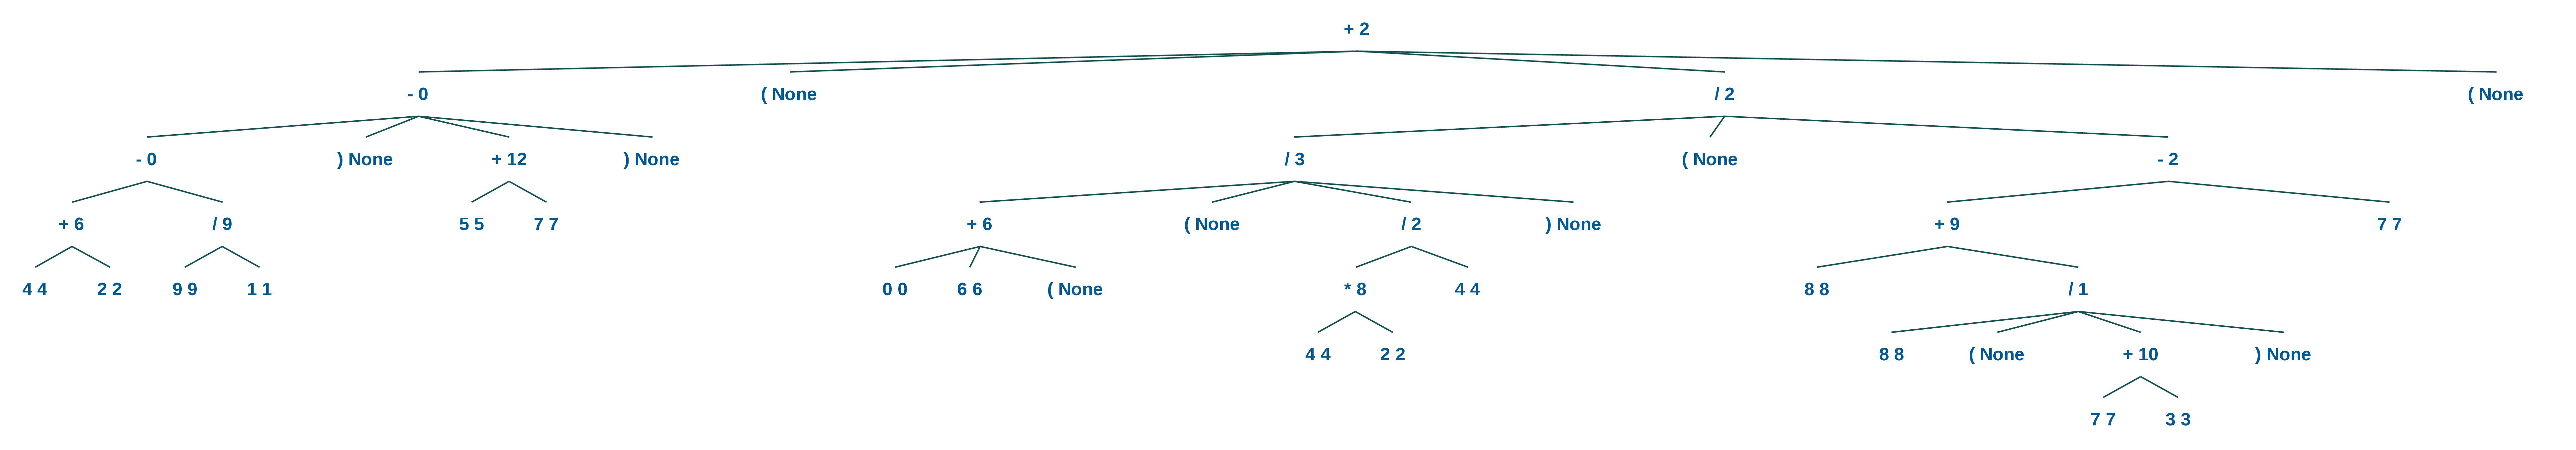

GT: 6+(2-7)/(2*7+8-(9*(9-5-5)+(3+5)))*(6-2) = 6
PD: 6+(2-7(/(2*7+8-(9*(9-5-5)+(3+5)(1*(6-2) = None


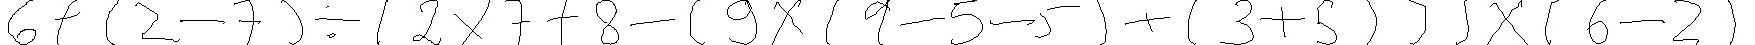

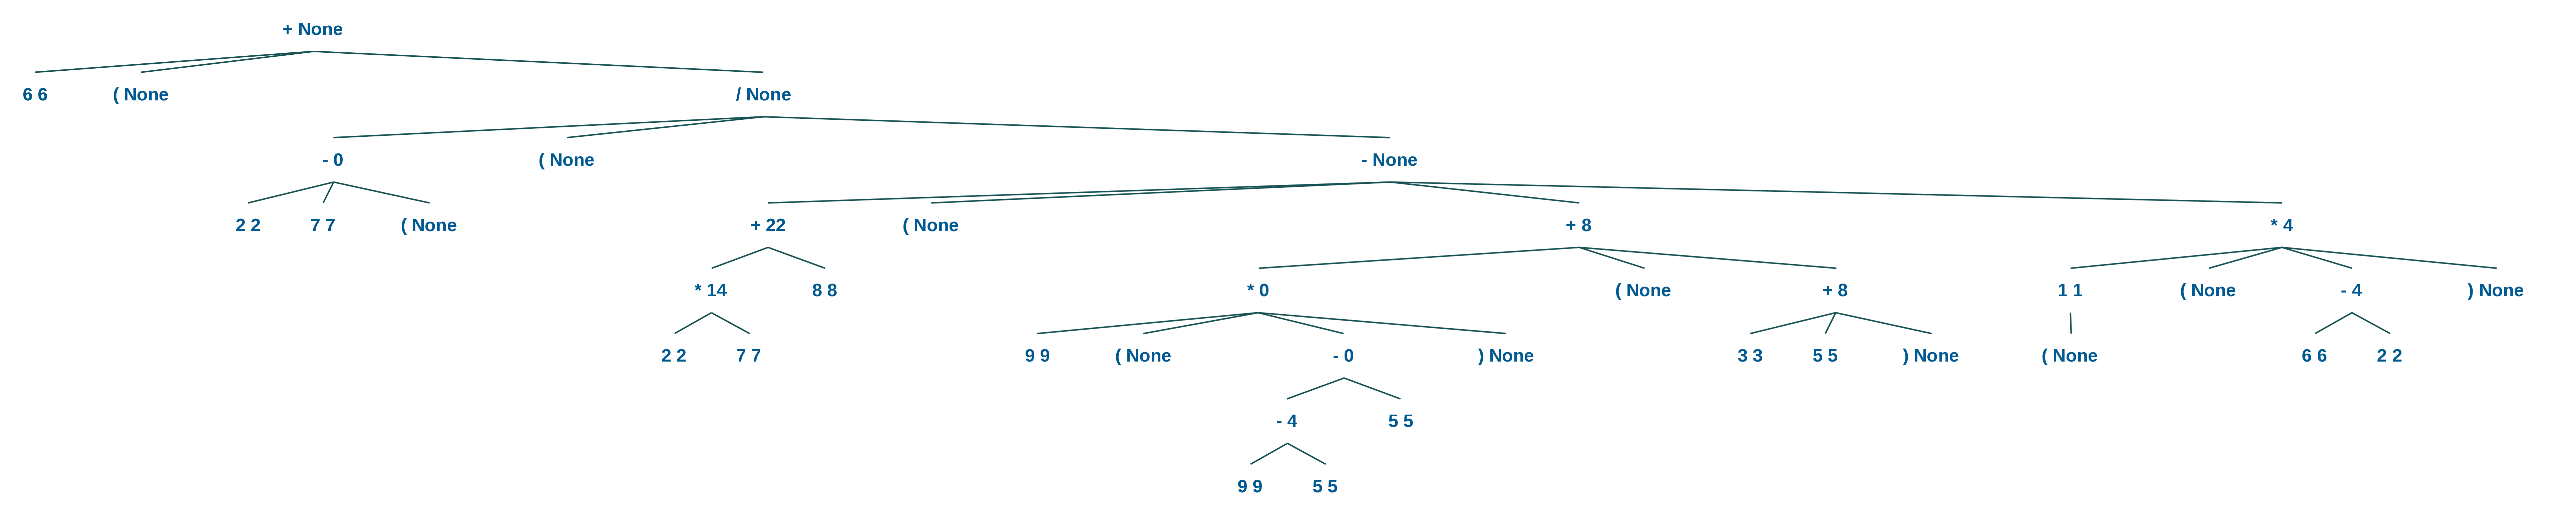

GT: (9-2+(4+7)-2)*(9+0+(4-4)-(3+(2+0)-(2-9)))/(9/1) = 8
PD: (9-2+(4+7)-2)*(9+0+(4-4(-(3+(2+0)-(2-9)))/(9/1) = 8


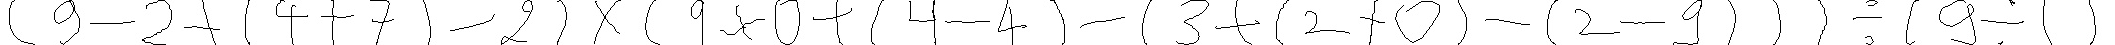

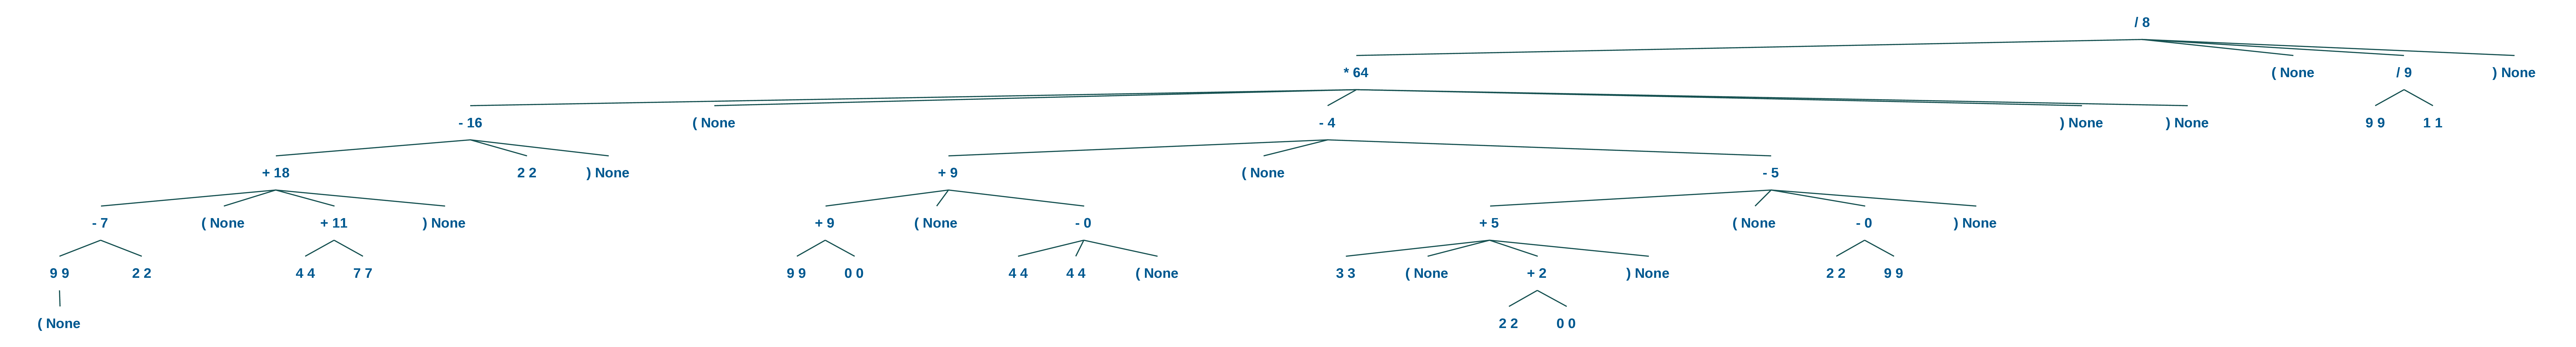

GT: (2-(1+3+1*1)+5/(3+(3/2-5*6*0))*4)/((9+1)/(6/4)-(6-7)) = 1
PD: (1-(1+3+1*1)+5/(0+(3/2-5*6*0()*4)/((9+1)/(6/4)-(6-7)( = 3


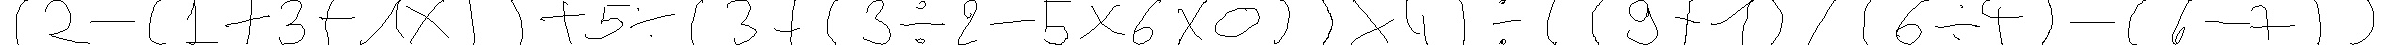

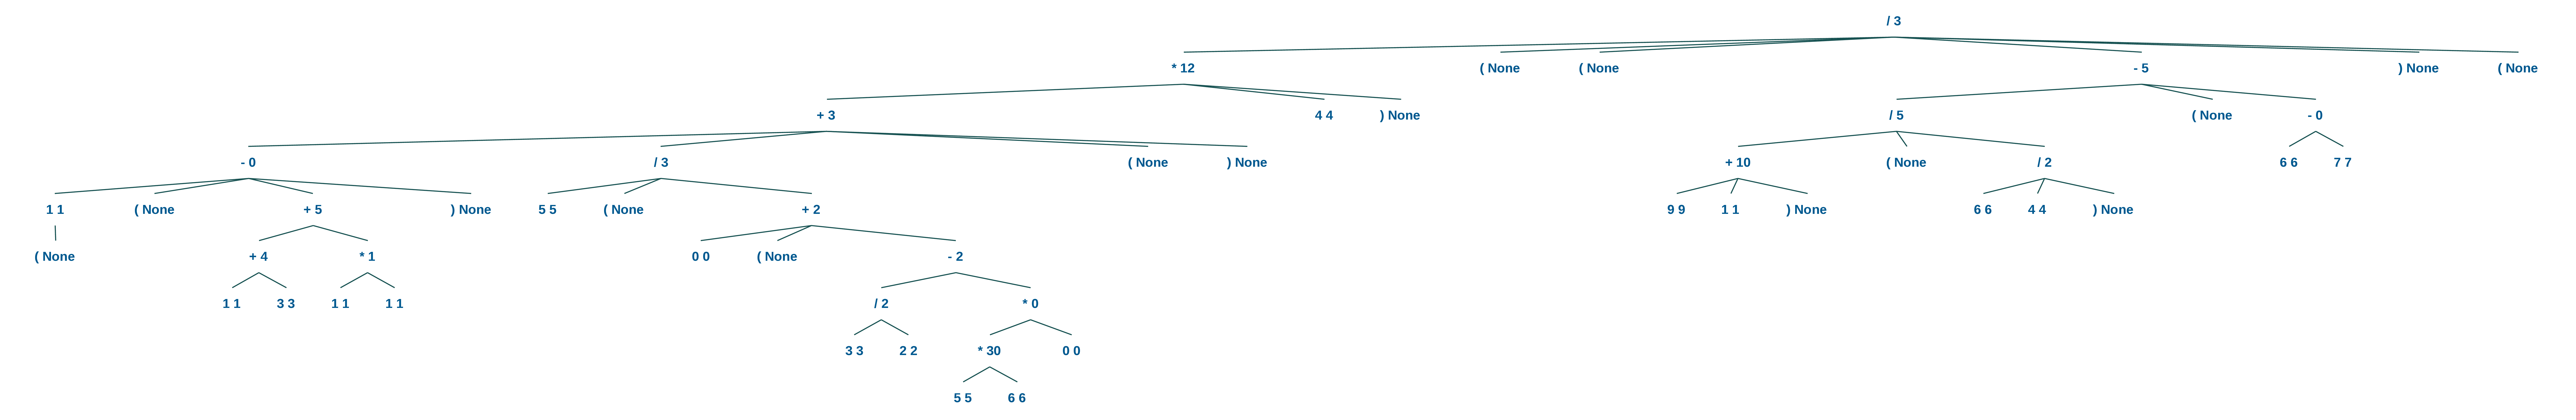

Test subset  5
GT: 1*(((5+7+7+8*7)*9+7-8*9+2)*(3+(2+0))*(3/3)) = 3060
PD: 1*(((5+7+7+8*7(*9+9-8*9+2)*(3+(2+0()*(3/3() = None


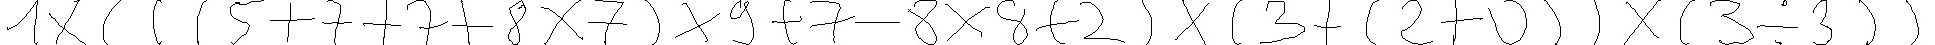

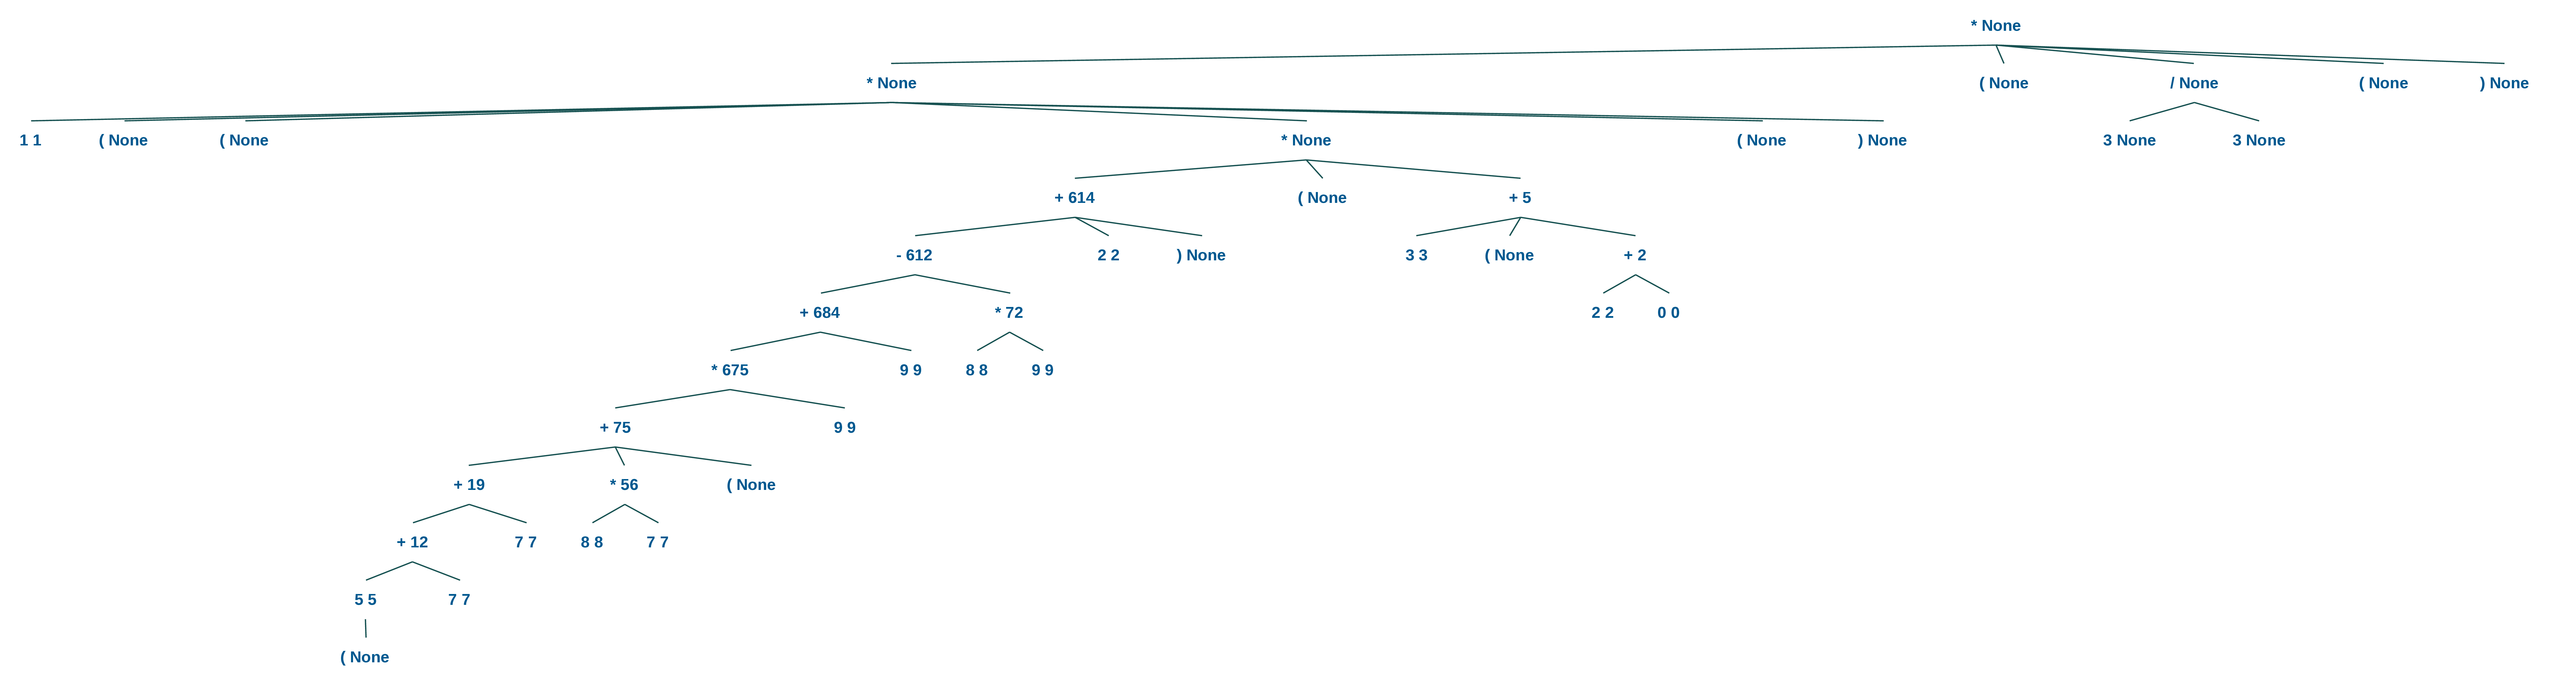

GT: (5-4*4)*((6+4)*((9-2)*9))-(9-1+9)/(0*9*((2-6)/9)+2)+5*1-4/4 = 4
PD: (5-4*4)*((6+4(*((9-2)*9((-(9-1+9)/(0*9*((2-6(/9(+2)+5*1-4/4 = 0


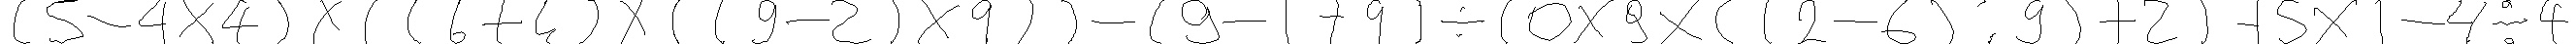

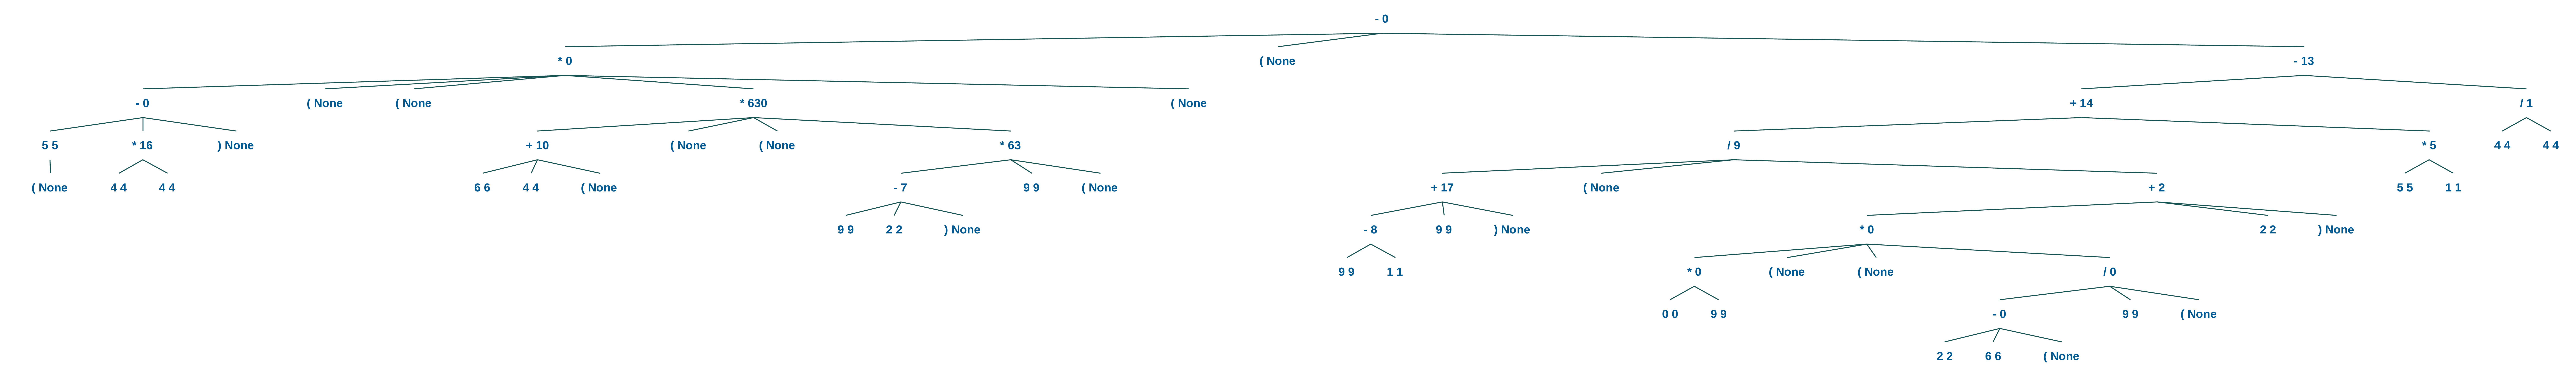

GT: (9+7)*9-(7+1-(4-6))*(1-(5-7)-0)+(5+(7+3))/5 = 139
PD: (9+7)*9-(7+1-(4-6))*(1-(5-7)-0(+(5+(7+3))/5 = 139


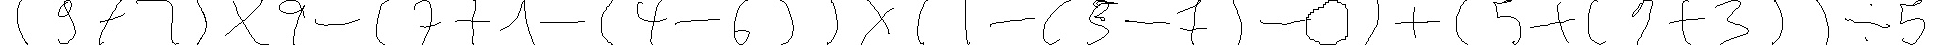

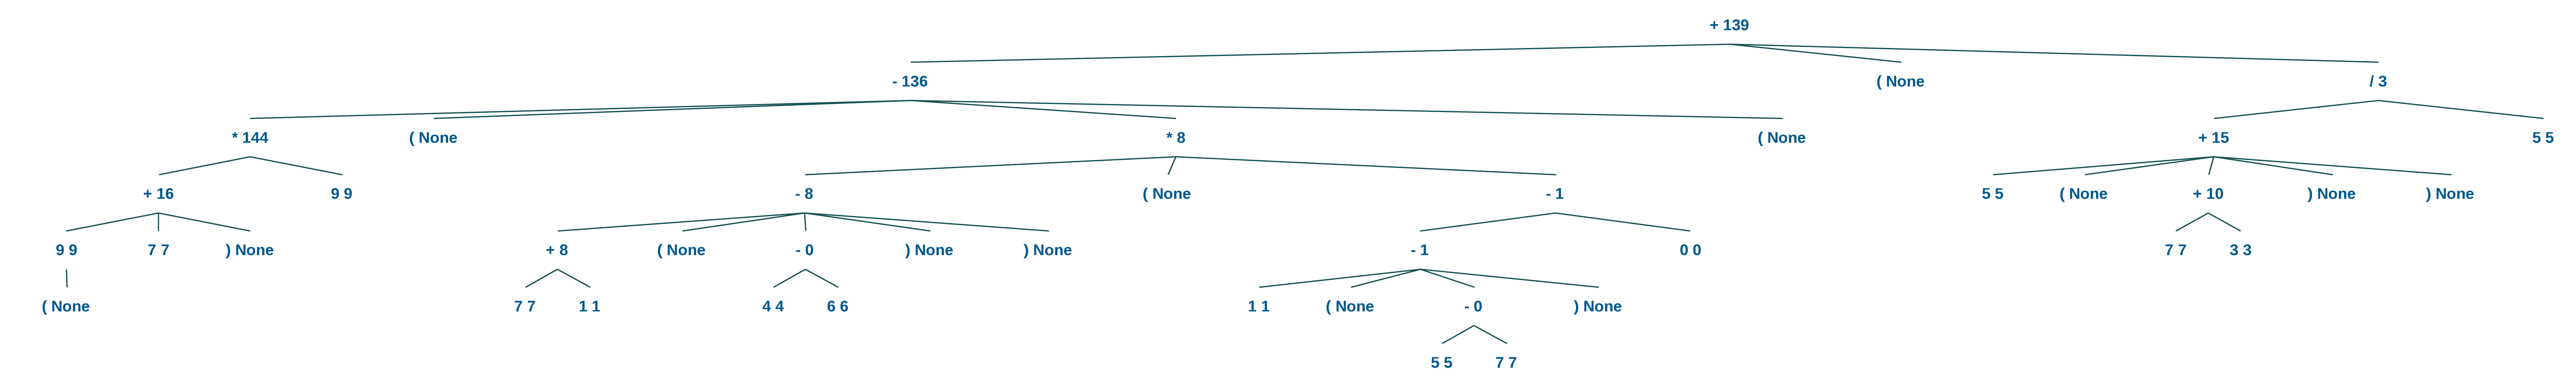

GT: (9*3/(6*8/((4+7)*(2*1)))-(4/7/1-6*2))*(2*7*7+1) = 891
PD: (9*3/(6*8/((4+7)*(2*1())-(4/7/1-6*2))*(2*7*7+1) = 891


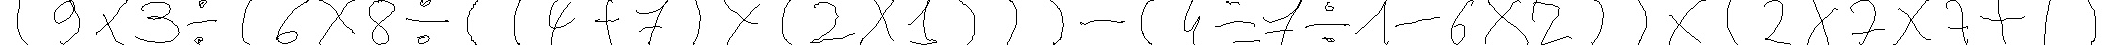

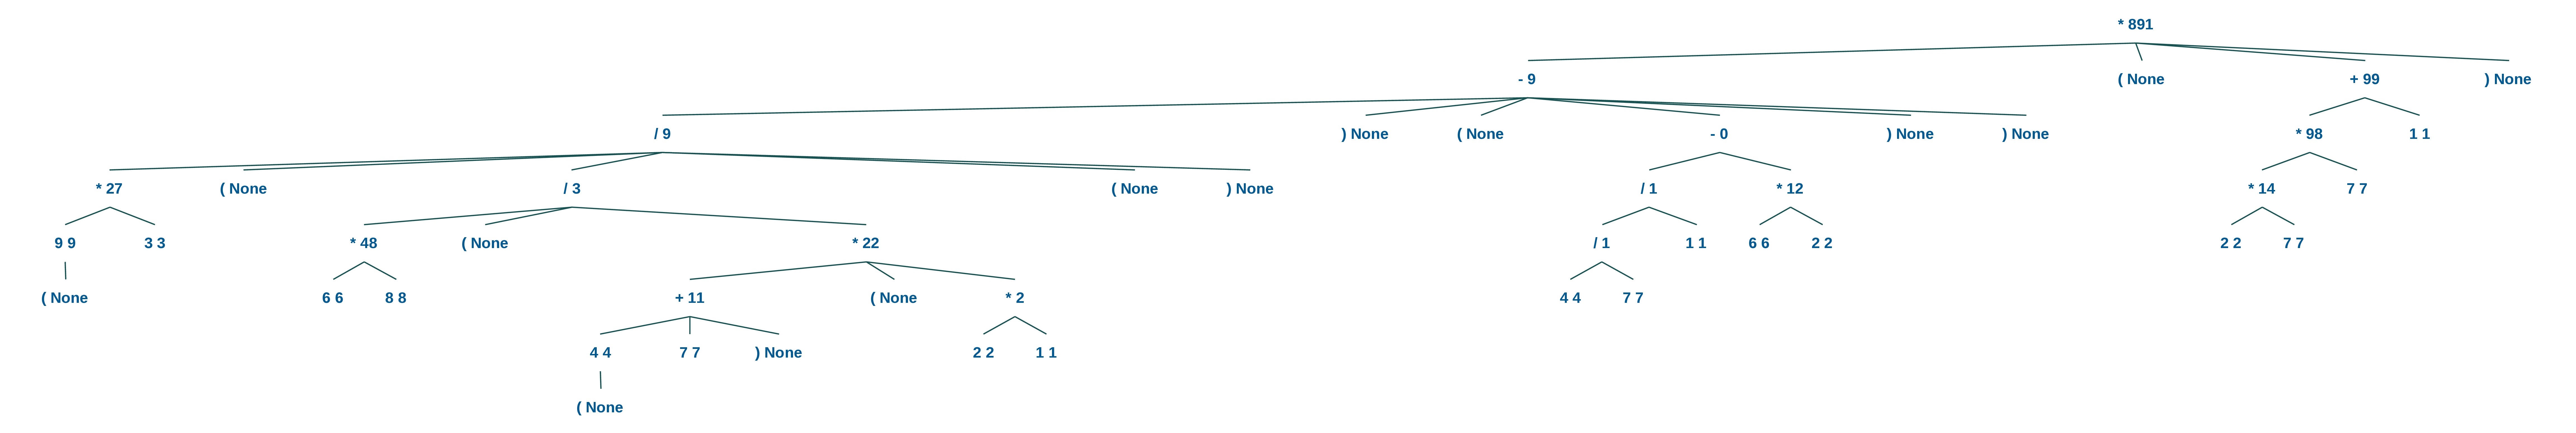

GT: (8*4*(1-4)-(2+(2-6/4))*3-7+2)/((1-0)*(2*(4*4)*7)) = 1
PD: (8*4*(1-4)-(2+(2-6/4))*3-7+2)/((1-0)*(2*(4*4)*7)) = 0


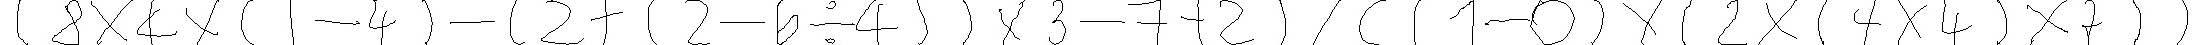

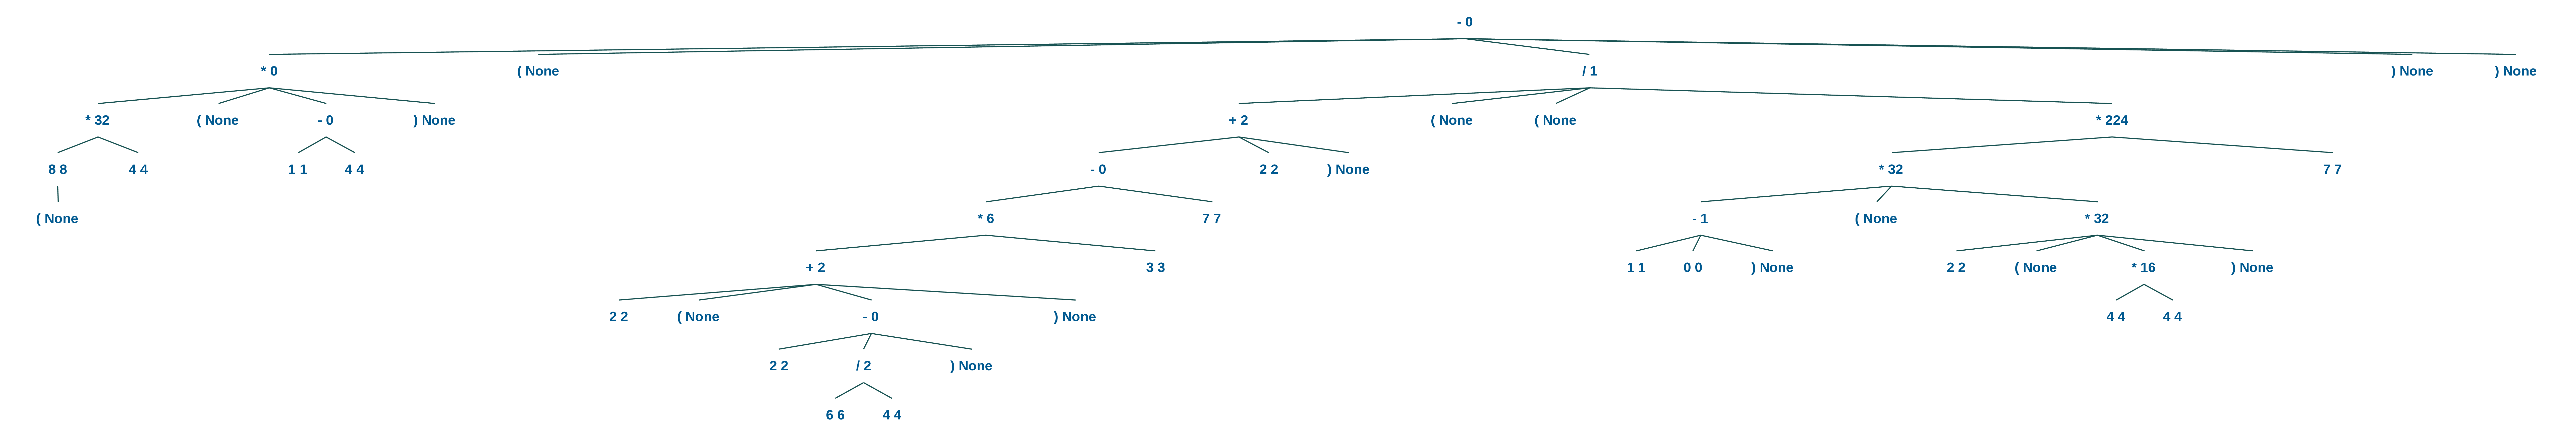

In [50]:
dataset = test_set
#dataset.filter_by_len(min_len=0, max_len=10)
n_examples = 5
model.eval()
for eval_idx in range(1, 6):
    print('Test subset ', eval_idx)
    dataset.filter_by_eval(eval_idx=eval_idx)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4, collate_fn=HINT_collate)
    with torch.no_grad():
        count = 0
        for sample in dataloader:
            res = sample['res']
            expr = sample['expr']
            dep = sample['head']
            model.clear_buffer()
            model.deduce(sample)
            ast = model.ASTs[0]
            tree = draw_ast(ast)
            print("GT:", expr[0], '=', res[0].item())
            print("PD:", ''.join(map(ID2SYM, ast.pt.sentence)), '=', ast.res())
            display(render_img(sample['img_paths'][0]))
            #display(tree)
            jupyter_draw_nltk_tree(tree)
            #input()
            count += 1
            if count == n_examples:
                break

# Abduction examples

In [4]:
sys.argv = sys.argv[:1]
args = parse_args()
args.syntax = True
args.semantics = True
model = Jointer(args)
model.to(DEVICE)
if args.perception_pretrain and not args.perception:
    model.perception.load({'model': torch.load(args.perception_pretrain)})

st_epoch = 0
if args.resume:
    st_epoch = model.load(args.resume)
    if st_epoch is None:
        st_epoch = 0

print(args)
model.print()

Namespace(curriculum=False, epochs=100, epochs_eval=10, excludes='!', fewshot=-1, output_dir='outputs/', perception=False, perception_pretrain='data/perception-pretrain/model.pth.tar_78.2_match', resume=None, seed=0, semantics=True, syntax=True)
ClusteringModel(
  (backbone): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_si

perception


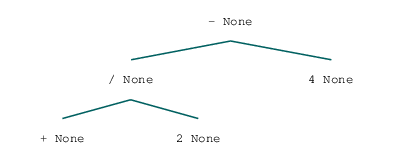

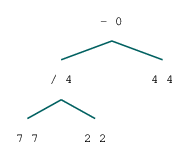

7/3-4 = 0


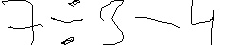

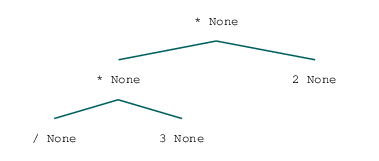

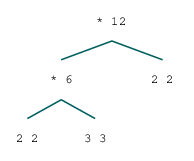

2*3*2 = 12


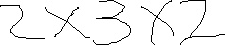

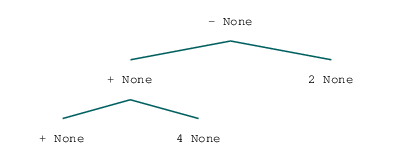

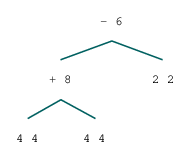

4+4-2 = 6


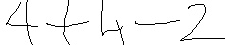

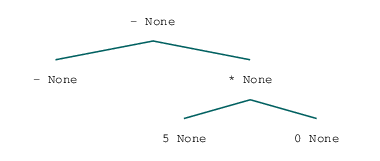

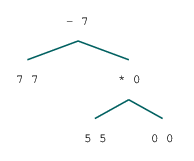

7-5*0 = 7


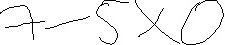

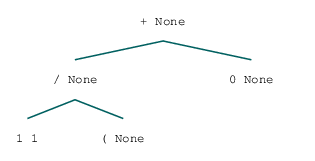

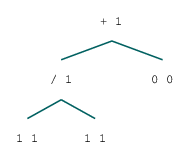

1/1+0 = 1


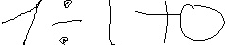

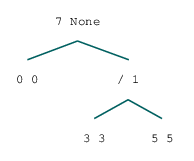

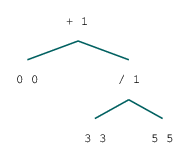

0+3/5 = 1


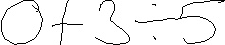

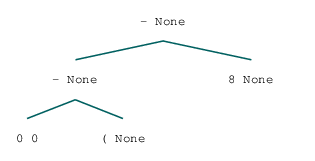

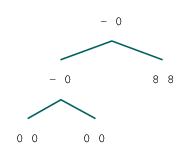

0-1-8 = 0


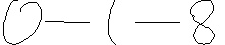

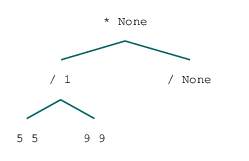

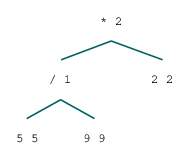

5/9*2 = 2


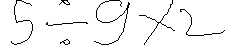

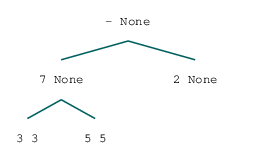

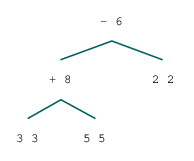

3+5-2 = 6


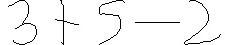

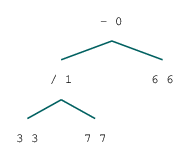

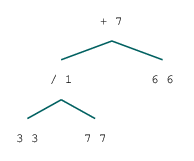

3/7+6 = 7


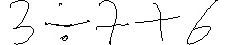

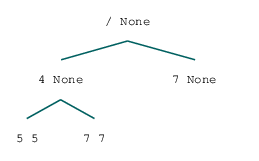

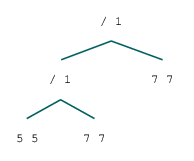

5/7/4 = 1


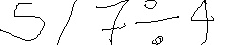

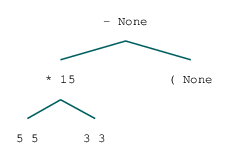

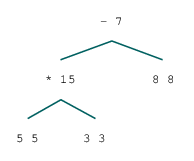

5*3-8 = 7


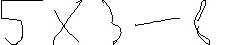

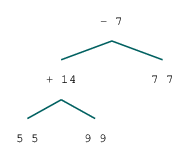

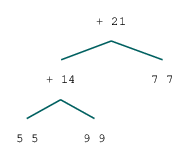

5+9+7 = 21


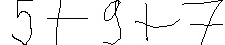

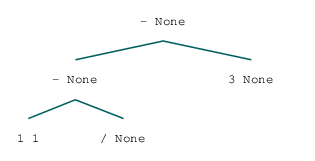

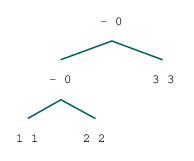

1-2-3 = 0


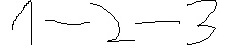

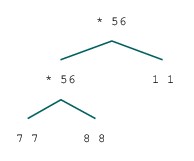

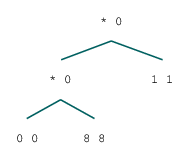

4*0*1 = 0


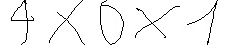

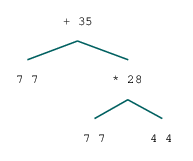

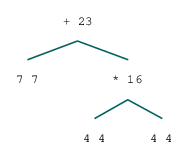

7+4*4 = 23


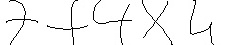

KeyboardInterrupt: Interrupted by user

In [14]:
dataset = val_set
dataset.filter_by_len(min_len=5, max_len=5)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=HINT_collate)
model.eval() 
model.epoch = 1
print(model.learned_module)
model.clear_buffer()
with torch.no_grad():
    for sample in dataloader:
        res = sample['res']
        expr = sample['expr']
        dep = sample['head']

        model.clear_buffer()
        model.deduce(sample)
        model.abduce(res, sample['img_paths'])
        if model.buffer:
            ast = model.ASTs[0]
            ast_abduce = model.buffer[0]
            if ast.res() == ast_abduce.res():
                continue
            display(draw_ast(ast))
            display(draw_ast(ast_abduce))
            print(expr[0], '=', res[0].item())
            display(render_img(sample['img_paths'][0]))
            input()
        
        